## Author: **_Rajat Agrawal_**
## Created on : 09-07-2023

## Aim: Generate New Pokemons from the original dataset.<br>
In this notebook we'll build, train, and test a Generative Adversarial Networks (GANs) model.

# Import libraries

In [1]:
# Import all required libraries
import os
import time

# For data visualization
import matplotlib.pyplot as plt

# import cv2 for image reading and image processing
import cv2

# tensorflow - to implement neural network
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm

In [ ]:
#@title GDrive IDs for the Dataset
# Download Dataset from Gdrive id

!gdown --id <id>

# Unzip the dataset

Note: Load the dataset `.zip` file before unzipping.

In [ ]:
# Unzip the dataset file
!unzip /content/pokemon_image_dataset.zip

# Explore the data

# name of the image:  20.jpg


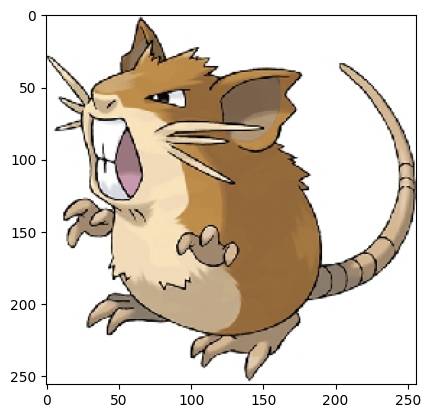

20.jpg


In [4]:
# Defining the path to dataset directory
# 'DATADIR' will hold the path to downloaded dataset.

DATADIR = "/content/pokemon_jpg/pokemon_jpg"
# Let's plot one image and see how it looks.
for img in os.listdir(DATADIR):
    img_array = cv2.imread(os.path.join(DATADIR, img))
    print("# name of the image: ", img) # name of the image
    # converting BGR to RGB as opencv read images in BGR format.
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_array)
    plt.show()
    print(img)
    break

## Image shape

In [5]:
# checking image shape (Not req.)
print("image shape: ", img_array.shape)

image shape:  (256, 256, 3)


In [ ]:
## Check if any image have a different shape than this: (256, 256, 3)
# c=0
# for img in os.listdir(DATADIR):
#     img_array_ = cv2.imread(os.path.join(DATADIR, img))
#     s_0 = img_array_.shape[0]
#     s_1 = img_array_.shape[0]
#     # print(s_0, s_1)
#     if s_0 != 256 or s_1 != 256:
#         print(img)
#     else:
#         c+=1
# print(c)

819


# Create training batches

In [6]:
batch_size = 128
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Preprocessing function for image normalization and resizing
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # Not required
    return image

# Load and preprocess images from the directory
image_paths = [os.path.join(DATADIR, img) for img in os.listdir(DATADIR)]
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(tf.io.read_file)
dataset = dataset.map(preprocess_image)

# Create training batches
dataset = dataset.batch(batch_size)

## Visualising a batch of real image data

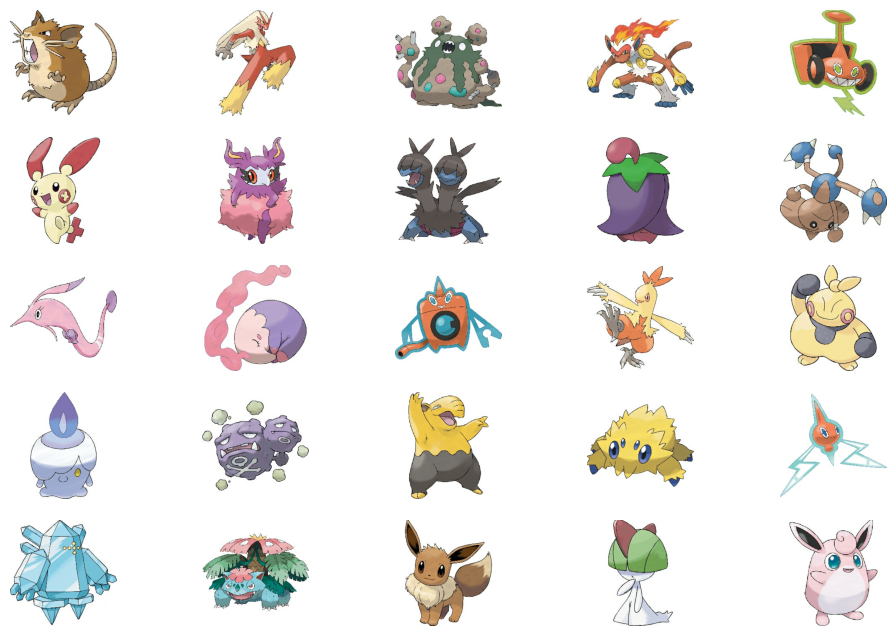

In [7]:
plt.figure(figsize = (12, 8))

for images in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

Retrieving and plotting  a sample image from batch data and checking its shape. Note that as images are colored, third dimension(channel) is 3

<class 'tensorflow.python.framework.ops.EagerTensor'>


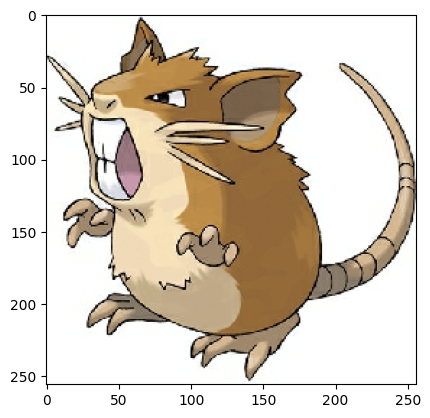

In [8]:
for batch in dataset:
    plt.imshow(batch[0])
    print(type(batch[0]))
    break

# Generator

## Random weights initializer

In [9]:
init_weights_kernel = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

## Generator model architecture

In [10]:
def generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape = (100, )))
    model.add(layers.Dense(16 * 16 * 256))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((16, 16, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel , use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size = 4, padding = 'same', strides = 2, activation = 'tanh',
                                     kernel_initializer = init_weights_kernel, use_bias = False))


    return model

## Building the generator model and summary is obtained

---



In [11]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      5

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Check the generator

Using the (as yet untrained) generator to create an random colored image.

In [12]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 256, 256, 3])

In [13]:
generated_image[0, :5, :5]

<tf.Tensor: shape=(5, 5, 3), dtype=float32, numpy=
array([[[ 9.95653500e-06,  6.10916595e-06, -1.08805425e-05],
        [-1.22684633e-05,  2.13837075e-06, -1.47625883e-06],
        [ 2.45259780e-05, -2.24038831e-05,  2.60323322e-05],
        [-3.54825024e-05,  7.33257621e-05, -1.25187726e-05],
        [-3.24846151e-05, -2.83817335e-05,  1.31615016e-05]],

       [[-4.66026686e-05, -3.78354562e-05, -3.69864647e-05],
        [-5.96041209e-05, -7.97801404e-05,  5.02376388e-05],
        [-6.12163858e-05, -7.17913426e-05, -4.80777562e-05],
        [-9.90481349e-05, -2.47998123e-05,  1.99247770e-05],
        [-7.71989435e-05, -1.90468490e-05, -1.45228289e-04]],

       [[-1.79681301e-05, -2.22323124e-05, -2.91543620e-06],
        [-1.84529963e-05, -3.41978011e-06,  1.22375823e-05],
        [-8.74630587e-06, -6.61989325e-05,  2.74970280e-05],
        [ 7.63663920e-05, -1.07382482e-04, -3.58042998e-05],
        [-1.16675539e-04, -7.10428139e-05,  7.55125220e-05]],

       [[-6.06176945e-06,  2

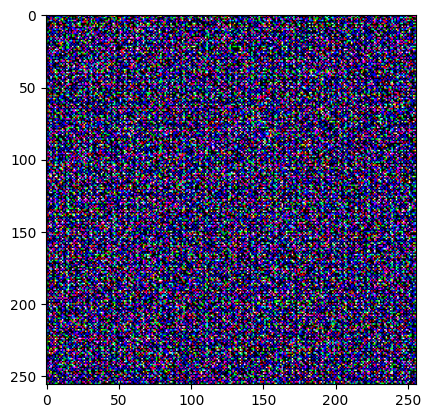

In [14]:
plt.imshow((generated_image[0, :, :, :] * 255 * 100))

# Discriminator

## Discriminator model architecture

In [15]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 2, input_shape = (256, 256, 3), padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False ))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.ZeroPadding2D(padding = ((0, 1), (0, 1))))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size = 3, strides=1, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

## Building the discriminator model and summary is obtained

In [16]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      864       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18432     
                                                                 
 zero_padding2d (ZeroPadding  (None, 65, 65, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 65, 65, 64)       256       
 hNormalization)                                      

## Check the discriminator

In [17]:
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.5000002]], shape=(1, 1), dtype=float32)


# Hyperparameters

## Loss function

In [18]:
# Initializing the loss function
bce = tf.keras.losses.BinaryCrossentropy()

In [19]:
# Defining the discriminator loss
def discriminator_loss(real_output, fake_output):
  # real_loss = bce(y_true, y_pred)
  # Here, y_true is `tf.ones_like(real_output)` and y_pred is `real_output`
  # This operation `tf.ones_like(real_output)` returns a tensor of the same type and shape as `real_output` with all elements set to 1.
  # Now, we have y_true as a tensor of ones and y_pred as a tensor of predicted class (0 or 1 as binary classification i.e. real or fake)
  # Similarly, for `tf.zeros_like(fake_output)`, a tensor of zeros for fake class.
    real_loss = bce(tf.ones_like(real_output), real_output)
  # Here, we are comapring `tf.zeros_like(fake_output)` with fake_output.
  # Here, y_true should be zero as discriminator should be able to classify the `fake_output` as fake. So, the
  # ground truth (y_true) is tensor of zeros and comparing it with predicted (y_pred) `fake_output`.
  #
  # Here, the BCE loss calculation is being done for a batch of images but not for a single image.
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

In [20]:
# Defining the generator loss
def generator_loss(fake_output):
  # gen_loss = bce(y_true, y_pred)
  # Here, y_true is `tf.ones_like(fake_output)` and y_pred is `fake_output`
  # This operation `tf.ones_like(fake_output)` returns a tensor of the same type and shape as `fake_output` with
  #  all elements set to 1. WHY? because we want generator to generate real like images which is class 1.
  # So, that's why we are comparing the predicted class with tensor of ones.
  # Now, we have y_true as a tensor of ones and y_pred as a tensor of predicted class (0 or 1 as binary classification i.e. real or fake)
  # And, here  `fake_output` signifies that the loss is being calculated for generated images.
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

## Optimizer

In [21]:
# Initializing the optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

## Checkpoints

In [34]:
# Creating checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_n')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

# Other parameters

In [36]:
# Hyperparameters
epochs = 600
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
def generate_and_plot_images(model, epoch, test_input):

    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.savefig('/content/generated_batches/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the models (Generator and Discriminator)

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [26]:
# Define the train function
def train(dataset, epochs):

    gen_loss_list = []
    disc_loss_list = []

    real_score_list = []
    fake_score_list = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)

            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches

        print('Losses after epoch %5d: generator %.3f, discriminator %.3f,\
               real_score %.2f%%, fake_score %.2f%%'  %
              (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        # After every 10 epochs save checkpoint and preview generated output
        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

              generate_and_plot_images(generator, epoch, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/400 [00:00<?, ?it/s]

Training started with  epoch 1 with 7 batches..


  0%|          | 1/400 [00:04<32:30,  4.89s/it]

Losses after epoch     1: generator 4.381, discriminator 0.098,               real_score 99.03%, fake_score 6.41%
Time for epoch 1 is 4.889432430267334 sec
Training started with  epoch 2 with 7 batches..


  0%|          | 2/400 [00:09<32:19,  4.87s/it]

Losses after epoch     2: generator 5.563, discriminator 0.055,               real_score 97.52%, fake_score 2.33%
Time for epoch 2 is 4.859224796295166 sec
Training started with  epoch 3 with 7 batches..


  1%|          | 3/400 [00:14<32:15,  4.87s/it]

Losses after epoch     3: generator 5.910, discriminator 0.041,               real_score 98.57%, fake_score 2.31%
Time for epoch 3 is 4.874941825866699 sec
Training started with  epoch 4 with 7 batches..


  1%|          | 4/400 [00:19<32:20,  4.90s/it]

Losses after epoch     4: generator 4.105, discriminator 0.126,               real_score 99.93%, fake_score 8.78%
Time for epoch 4 is 4.936197757720947 sec
Training started with  epoch 5 with 7 batches..


  1%|▏         | 5/400 [00:24<32:14,  4.90s/it]

Losses after epoch     5: generator 4.657, discriminator 0.060,               real_score 99.48%, fake_score 4.63%
Time for epoch 5 is 4.8889453411102295 sec
Training started with  epoch 6 with 7 batches..


  2%|▏         | 6/400 [00:29<32:10,  4.90s/it]

Losses after epoch     6: generator 4.436, discriminator 0.058,               real_score 99.76%, fake_score 4.98%
Time for epoch 6 is 4.903817653656006 sec
Training started with  epoch 7 with 7 batches..


  2%|▏         | 7/400 [00:34<32:09,  4.91s/it]

Losses after epoch     7: generator 4.342, discriminator 0.122,               real_score 99.01%, fake_score 7.23%
Time for epoch 7 is 4.931027173995972 sec
Training started with  epoch 8 with 7 batches..


  2%|▏         | 8/400 [00:39<32:06,  4.92s/it]

Losses after epoch     8: generator 4.824, discriminator 0.084,               real_score 98.73%, fake_score 4.56%
Time for epoch 8 is 4.9241414070129395 sec
Training started with  epoch 9 with 7 batches..


  2%|▏         | 9/400 [00:44<32:10,  4.94s/it]

Losses after epoch     9: generator 5.492, discriminator 0.043,               real_score 98.23%, fake_score 2.21%
Time for epoch 9 is 4.981244802474976 sec
Training started with  epoch 10 with 7 batches..
Losses after epoch    10: generator 4.977, discriminator 0.088,               real_score 97.96%, fake_score 4.37%


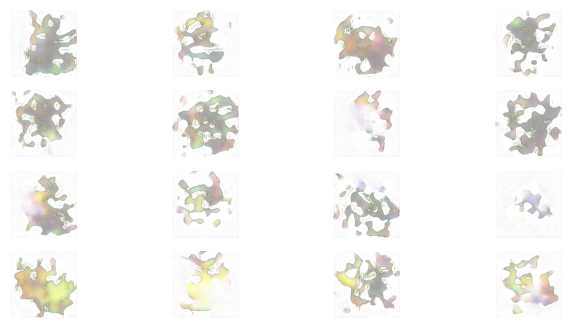

  2%|▎         | 10/400 [00:51<36:20,  5.59s/it]

Time for epoch 10 is 7.049270391464233 sec
Training started with  epoch 11 with 7 batches..


  3%|▎         | 11/400 [00:56<35:18,  5.44s/it]

Losses after epoch    11: generator 4.831, discriminator 0.091,               real_score 97.01%, fake_score 4.47%
Time for epoch 11 is 5.113174676895142 sec
Training started with  epoch 12 with 7 batches..


  3%|▎         | 12/400 [01:01<34:15,  5.30s/it]

Losses after epoch    12: generator 5.237, discriminator 0.048,               real_score 99.16%, fake_score 3.40%
Time for epoch 12 is 4.963627815246582 sec
Training started with  epoch 13 with 7 batches..


  3%|▎         | 13/400 [01:06<33:49,  5.24s/it]

Losses after epoch    13: generator 3.928, discriminator 0.112,               real_score 99.60%, fake_score 8.21%
Time for epoch 13 is 5.114258766174316 sec
Training started with  epoch 14 with 7 batches..


  4%|▎         | 14/400 [01:11<33:14,  5.17s/it]

Losses after epoch    14: generator 3.913, discriminator 0.117,               real_score 99.75%, fake_score 8.93%
Time for epoch 14 is 4.992549419403076 sec
Training started with  epoch 15 with 7 batches..


  4%|▍         | 15/400 [01:16<32:50,  5.12s/it]

Losses after epoch    15: generator 4.445, discriminator 0.089,               real_score 99.20%, fake_score 5.65%
Time for epoch 15 is 4.999538898468018 sec
Training started with  epoch 16 with 7 batches..


  4%|▍         | 16/400 [01:21<32:36,  5.10s/it]

Losses after epoch    16: generator 4.811, discriminator 0.061,               real_score 99.43%, fake_score 4.48%
Time for epoch 16 is 5.042569637298584 sec
Training started with  epoch 17 with 7 batches..


  4%|▍         | 17/400 [01:26<32:24,  5.08s/it]

Losses after epoch    17: generator 4.920, discriminator 0.097,               real_score 97.11%, fake_score 4.66%
Time for epoch 17 is 5.034829378128052 sec
Training started with  epoch 18 with 7 batches..


  4%|▍         | 18/400 [01:31<32:24,  5.09s/it]

Losses after epoch    18: generator 7.162, discriminator 0.121,               real_score 92.85%, fake_score 0.39%
Time for epoch 18 is 5.111977577209473 sec
Training started with  epoch 19 with 7 batches..


  5%|▍         | 19/400 [01:36<32:13,  5.08s/it]

Losses after epoch    19: generator 7.625, discriminator 0.079,               real_score 93.70%, fake_score 0.41%
Time for epoch 19 is 5.040445327758789 sec
Training started with  epoch 20 with 7 batches..
Losses after epoch    20: generator 5.783, discriminator 0.038,               real_score 99.27%, fake_score 2.51%


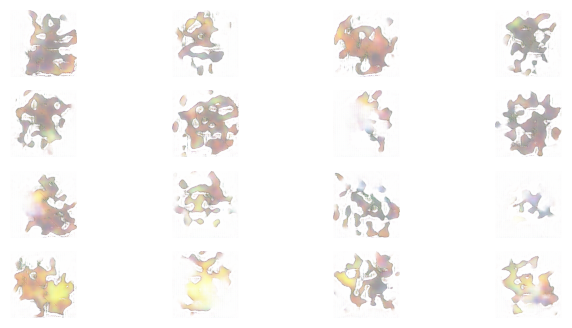

  5%|▌         | 20/400 [01:42<34:04,  5.38s/it]

Time for epoch 20 is 6.086708068847656 sec
Training started with  epoch 21 with 7 batches..


  5%|▌         | 21/400 [01:47<33:22,  5.28s/it]

Losses after epoch    21: generator 5.223, discriminator 0.045,               real_score 99.55%, fake_score 3.42%
Time for epoch 21 is 5.062237977981567 sec
Training started with  epoch 22 with 7 batches..


  6%|▌         | 22/400 [01:52<32:49,  5.21s/it]

Losses after epoch    22: generator 4.084, discriminator 0.098,               real_score 99.59%, fake_score 7.27%
Time for epoch 22 is 5.034922122955322 sec
Training started with  epoch 23 with 7 batches..


  6%|▌         | 23/400 [01:58<32:37,  5.19s/it]

Losses after epoch    23: generator 5.352, discriminator 0.039,               real_score 98.90%, fake_score 2.54%
Time for epoch 23 is 5.142608642578125 sec
Training started with  epoch 24 with 7 batches..


  6%|▌         | 24/400 [02:03<32:16,  5.15s/it]

Losses after epoch    24: generator 6.263, discriminator 0.033,               real_score 97.93%, fake_score 1.11%
Time for epoch 24 is 5.0526158809661865 sec
Training started with  epoch 25 with 7 batches..


  6%|▋         | 25/400 [02:08<31:59,  5.12s/it]

Losses after epoch    25: generator 0.079, discriminator 4.278,               real_score 100.00%, fake_score 93.52%
Time for epoch 25 is 5.0388171672821045 sec
Training started with  epoch 26 with 7 batches..


  6%|▋         | 26/400 [02:13<31:45,  5.10s/it]

Losses after epoch    26: generator 1.946, discriminator 0.696,               real_score 100.00%, fake_score 33.87%
Time for epoch 26 is 5.0419652462005615 sec
Training started with  epoch 27 with 7 batches..


  7%|▋         | 27/400 [02:18<31:43,  5.10s/it]

Losses after epoch    27: generator 7.809, discriminator 0.088,               real_score 92.85%, fake_score 0.27%
Time for epoch 27 is 5.1145923137664795 sec
Training started with  epoch 28 with 7 batches..


  7%|▋         | 28/400 [02:23<31:35,  5.10s/it]

Losses after epoch    28: generator 19.616, discriminator 5.638,               real_score 5.50%, fake_score 0.00%
Time for epoch 28 is 5.077295303344727 sec
Training started with  epoch 29 with 7 batches..


  7%|▋         | 29/400 [02:28<31:27,  5.09s/it]

Losses after epoch    29: generator 1.787, discriminator 0.779,               real_score 100.00%, fake_score 35.33%
Time for epoch 29 is 5.069165945053101 sec
Training started with  epoch 30 with 7 batches..
Losses after epoch    30: generator 3.266, discriminator 0.255,               real_score 99.95%, fake_score 17.03%


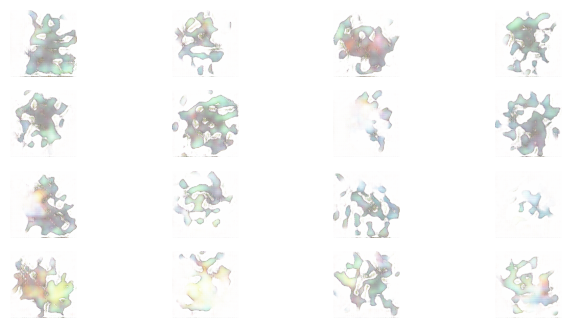

  8%|▊         | 30/400 [02:34<33:32,  5.44s/it]

Time for epoch 30 is 6.2530248165130615 sec
Training started with  epoch 31 with 7 batches..


  8%|▊         | 31/400 [02:39<32:50,  5.34s/it]

Losses after epoch    31: generator 11.973, discriminator 0.053,               real_score 97.53%, fake_score 1.55%
Time for epoch 31 is 5.10512638092041 sec
Training started with  epoch 32 with 7 batches..


  8%|▊         | 32/400 [02:44<32:17,  5.26s/it]

Losses after epoch    32: generator 6.041, discriminator 0.085,               real_score 98.04%, fake_score 4.45%
Time for epoch 32 is 5.0865607261657715 sec
Training started with  epoch 33 with 7 batches..


  8%|▊         | 33/400 [02:49<31:53,  5.21s/it]

Losses after epoch    33: generator 2.597, discriminator 0.477,               real_score 99.95%, fake_score 25.52%
Time for epoch 33 is 5.096254348754883 sec
Training started with  epoch 34 with 7 batches..


  8%|▊         | 34/400 [02:55<31:37,  5.18s/it]

Losses after epoch    34: generator 4.873, discriminator 0.098,               real_score 99.68%, fake_score 6.96%
Time for epoch 34 is 5.110140800476074 sec
Training started with  epoch 35 with 7 batches..


  9%|▉         | 35/400 [03:00<31:24,  5.16s/it]

Losses after epoch    35: generator 0.003, discriminator 10.003,               real_score 100.00%, fake_score 99.73%
Time for epoch 35 is 5.111313104629517 sec
Training started with  epoch 36 with 7 batches..


  9%|▉         | 36/400 [03:05<31:15,  5.15s/it]

Losses after epoch    36: generator 0.346, discriminator 3.384,               real_score 100.00%, fake_score 80.87%
Time for epoch 36 is 5.122512578964233 sec
Training started with  epoch 37 with 7 batches..


  9%|▉         | 37/400 [03:10<31:18,  5.18s/it]

Losses after epoch    37: generator 5.388, discriminator 0.076,               real_score 99.59%, fake_score 4.80%
Time for epoch 37 is 5.231683969497681 sec
Training started with  epoch 38 with 7 batches..


 10%|▉         | 38/400 [03:15<31:08,  5.16s/it]

Losses after epoch    38: generator 15.228, discriminator 1.308,               real_score 56.73%, fake_score 0.00%
Time for epoch 38 is 5.12247896194458 sec
Training started with  epoch 39 with 7 batches..


 10%|▉         | 39/400 [03:20<30:59,  5.15s/it]

Losses after epoch    39: generator 11.042, discriminator 0.286,               real_score 80.70%, fake_score 0.04%
Time for epoch 39 is 5.130040645599365 sec
Training started with  epoch 40 with 7 batches..
Losses after epoch    40: generator 5.667, discriminator 0.037,               real_score 99.73%, fake_score 3.05%


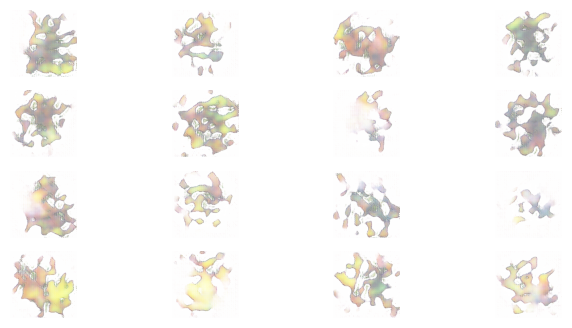

 10%|█         | 40/400 [03:27<32:55,  5.49s/it]

Time for epoch 40 is 6.267271041870117 sec
Training started with  epoch 41 with 7 batches..


 10%|█         | 41/400 [03:32<32:12,  5.38s/it]

Losses after epoch    41: generator 11.062, discriminator 0.219,               real_score 83.87%, fake_score 0.03%
Time for epoch 41 is 5.140976428985596 sec
Training started with  epoch 42 with 7 batches..


 10%|█         | 42/400 [03:37<31:39,  5.30s/it]

Losses after epoch    42: generator 5.941, discriminator 0.063,               real_score 97.68%, fake_score 2.26%
Time for epoch 42 is 5.11815619468689 sec
Training started with  epoch 43 with 7 batches..


 11%|█         | 43/400 [03:42<31:14,  5.25s/it]

Losses after epoch    43: generator 5.745, discriminator 0.043,               real_score 99.69%, fake_score 3.01%
Time for epoch 43 is 5.119965553283691 sec
Training started with  epoch 44 with 7 batches..


 11%|█         | 44/400 [03:47<31:08,  5.25s/it]

Losses after epoch    44: generator 6.267, discriminator 0.049,               real_score 98.25%, fake_score 2.57%
Time for epoch 44 is 5.237613201141357 sec
Training started with  epoch 45 with 7 batches..


 11%|█▏        | 45/400 [03:52<30:50,  5.21s/it]

Losses after epoch    45: generator 7.238, discriminator 0.027,               real_score 98.31%, fake_score 0.69%
Time for epoch 45 is 5.1266186237335205 sec
Training started with  epoch 46 with 7 batches..


 12%|█▏        | 46/400 [03:58<30:38,  5.19s/it]

Losses after epoch    46: generator 5.911, discriminator 0.057,               real_score 98.87%, fake_score 3.68%
Time for epoch 46 is 5.146274566650391 sec
Training started with  epoch 47 with 7 batches..


 12%|█▏        | 47/400 [04:03<30:25,  5.17s/it]

Losses after epoch    47: generator 7.284, discriminator 0.069,               real_score 94.94%, fake_score 0.70%
Time for epoch 47 is 5.12294340133667 sec
Training started with  epoch 48 with 7 batches..


 12%|█▏        | 48/400 [04:08<30:17,  5.16s/it]

Losses after epoch    48: generator 5.139, discriminator 0.060,               real_score 99.42%, fake_score 4.59%
Time for epoch 48 is 5.142186164855957 sec
Training started with  epoch 49 with 7 batches..


 12%|█▏        | 49/400 [04:13<30:09,  5.15s/it]

Losses after epoch    49: generator 6.657, discriminator 0.034,               real_score 98.39%, fake_score 1.43%
Time for epoch 49 is 5.13085150718689 sec
Training started with  epoch 50 with 7 batches..
Losses after epoch    50: generator 5.027, discriminator 0.072,               real_score 99.06%, fake_score 4.75%


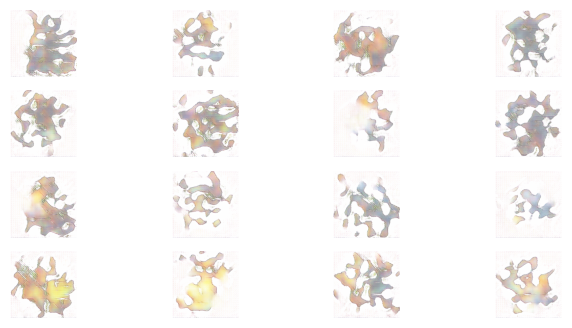

 12%|█▎        | 50/400 [04:20<32:49,  5.63s/it]

Time for epoch 50 is 6.726797580718994 sec
Training started with  epoch 51 with 7 batches..


 13%|█▎        | 51/400 [04:25<32:06,  5.52s/it]

Losses after epoch    51: generator 6.320, discriminator 0.052,               real_score 97.66%, fake_score 2.06%
Time for epoch 51 is 5.260751485824585 sec
Training started with  epoch 52 with 7 batches..


 13%|█▎        | 52/400 [04:30<31:21,  5.41s/it]

Losses after epoch    52: generator 5.420, discriminator 0.066,               real_score 97.57%, fake_score 3.25%
Time for epoch 52 is 5.139818429946899 sec
Training started with  epoch 53 with 7 batches..


 13%|█▎        | 53/400 [04:35<30:58,  5.36s/it]

Losses after epoch    53: generator 4.404, discriminator 0.114,               real_score 99.30%, fake_score 8.10%
Time for epoch 53 is 5.230461359024048 sec
Training started with  epoch 54 with 7 batches..


 14%|█▎        | 54/400 [04:40<30:30,  5.29s/it]

Losses after epoch    54: generator 4.295, discriminator 0.117,               real_score 99.29%, fake_score 7.81%
Time for epoch 54 is 5.14085054397583 sec
Training started with  epoch 55 with 7 batches..


 14%|█▍        | 55/400 [04:46<30:10,  5.25s/it]

Losses after epoch    55: generator 4.749, discriminator 0.069,               real_score 98.92%, fake_score 4.84%
Time for epoch 55 is 5.148498058319092 sec
Training started with  epoch 56 with 7 batches..


 14%|█▍        | 56/400 [04:51<29:53,  5.21s/it]

Losses after epoch    56: generator 4.621, discriminator 0.094,               real_score 98.21%, fake_score 5.16%
Time for epoch 56 is 5.130929470062256 sec
Training started with  epoch 57 with 7 batches..


 14%|█▍        | 57/400 [04:56<29:42,  5.20s/it]

Losses after epoch    57: generator 4.166, discriminator 0.156,               real_score 98.24%, fake_score 8.85%
Time for epoch 57 is 5.15454363822937 sec
Training started with  epoch 58 with 7 batches..


 14%|█▍        | 58/400 [05:01<29:43,  5.21s/it]

Losses after epoch    58: generator 6.390, discriminator 0.083,               real_score 94.85%, fake_score 1.26%
Time for epoch 58 is 5.249196767807007 sec
Training started with  epoch 59 with 7 batches..


 15%|█▍        | 59/400 [05:06<29:34,  5.20s/it]

Losses after epoch    59: generator 5.180, discriminator 0.058,               real_score 99.13%, fake_score 4.17%
Time for epoch 59 is 5.176796197891235 sec
Training started with  epoch 60 with 7 batches..
Losses after epoch    60: generator 4.194, discriminator 0.115,               real_score 99.35%, fake_score 8.03%


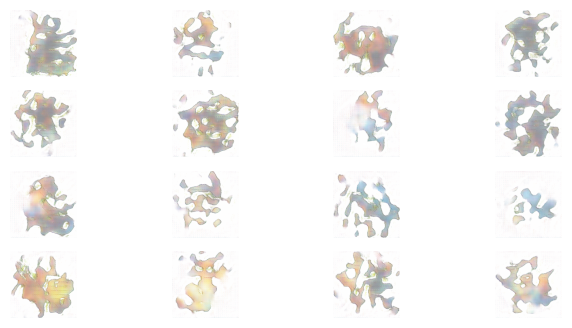

 15%|█▌        | 60/400 [05:13<31:42,  5.60s/it]

Time for epoch 60 is 6.510683536529541 sec
Training started with  epoch 61 with 7 batches..


 15%|█▌        | 61/400 [05:18<30:50,  5.46s/it]

Losses after epoch    61: generator 4.027, discriminator 0.094,               real_score 99.78%, fake_score 7.53%
Time for epoch 61 is 5.131714344024658 sec
Training started with  epoch 62 with 7 batches..


 16%|█▌        | 62/400 [05:23<30:11,  5.36s/it]

Losses after epoch    62: generator 4.986, discriminator 0.081,               real_score 98.73%, fake_score 5.21%
Time for epoch 62 is 5.132066965103149 sec
Training started with  epoch 63 with 7 batches..


 16%|█▌        | 63/400 [05:28<29:42,  5.29s/it]

Losses after epoch    63: generator 4.572, discriminator 0.096,               real_score 97.14%, fake_score 5.05%
Time for epoch 63 is 5.1232590675354 sec
Training started with  epoch 64 with 7 batches..


 16%|█▌        | 64/400 [05:33<29:23,  5.25s/it]

Losses after epoch    64: generator 4.089, discriminator 0.168,               real_score 98.93%, fake_score 9.86%
Time for epoch 64 is 5.146179437637329 sec
Training started with  epoch 65 with 7 batches..


 16%|█▋        | 65/400 [05:38<29:06,  5.21s/it]

Losses after epoch    65: generator 2.512, discriminator 0.293,               real_score 99.88%, fake_score 19.92%
Time for epoch 65 is 5.137134313583374 sec
Training started with  epoch 66 with 7 batches..


 16%|█▋        | 66/400 [05:44<28:54,  5.19s/it]

Losses after epoch    66: generator 4.751, discriminator 0.075,               real_score 97.96%, fake_score 3.96%
Time for epoch 66 is 5.141711950302124 sec
Training started with  epoch 67 with 7 batches..


 17%|█▋        | 67/400 [05:49<28:56,  5.21s/it]

Losses after epoch    67: generator 4.585, discriminator 0.097,               real_score 98.34%, fake_score 6.00%
Time for epoch 67 is 5.258228302001953 sec
Training started with  epoch 68 with 7 batches..


 17%|█▋        | 68/400 [05:54<28:44,  5.20s/it]

Losses after epoch    68: generator 6.357, discriminator 0.063,               real_score 96.87%, fake_score 2.02%
Time for epoch 68 is 5.150447368621826 sec
Training started with  epoch 69 with 7 batches..


 17%|█▋        | 69/400 [05:59<28:36,  5.19s/it]

Losses after epoch    69: generator 4.449, discriminator 0.107,               real_score 97.75%, fake_score 6.32%
Time for epoch 69 is 5.1623923778533936 sec
Training started with  epoch 70 with 7 batches..
Losses after epoch    70: generator 7.950, discriminator 0.240,               real_score 86.88%, fake_score 0.58%


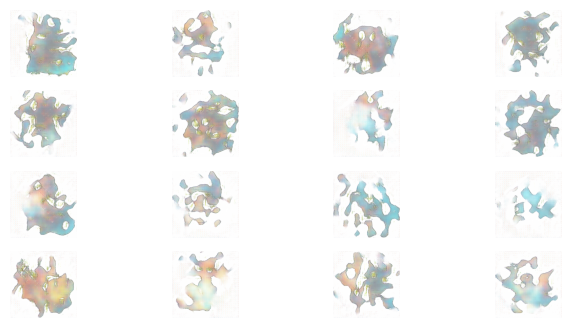

 18%|█▊        | 70/400 [06:05<30:20,  5.52s/it]

Time for epoch 70 is 6.2829978466033936 sec
Training started with  epoch 71 with 7 batches..


 18%|█▊        | 71/400 [06:11<29:38,  5.40s/it]

Losses after epoch    71: generator 4.097, discriminator 0.098,               real_score 99.65%, fake_score 7.19%
Time for epoch 71 is 5.142164707183838 sec
Training started with  epoch 72 with 7 batches..


 18%|█▊        | 72/400 [06:16<29:06,  5.33s/it]

Losses after epoch    72: generator 3.954, discriminator 0.126,               real_score 99.80%, fake_score 8.58%
Time for epoch 72 is 5.138442039489746 sec
Training started with  epoch 73 with 7 batches..


 18%|█▊        | 73/400 [06:21<28:41,  5.27s/it]

Losses after epoch    73: generator 4.460, discriminator 0.094,               real_score 98.78%, fake_score 6.09%
Time for epoch 73 is 5.123144626617432 sec
Training started with  epoch 74 with 7 batches..


 18%|█▊        | 74/400 [06:26<28:35,  5.26s/it]

Losses after epoch    74: generator 4.131, discriminator 0.074,               real_score 99.55%, fake_score 6.03%
Time for epoch 74 is 5.251137018203735 sec
Training started with  epoch 75 with 7 batches..


 19%|█▉        | 75/400 [06:31<28:16,  5.22s/it]

Losses after epoch    75: generator 4.724, discriminator 0.114,               real_score 96.75%, fake_score 5.41%
Time for epoch 75 is 5.123605012893677 sec
Training started with  epoch 76 with 7 batches..


 19%|█▉        | 76/400 [06:36<28:04,  5.20s/it]

Losses after epoch    76: generator 4.054, discriminator 0.110,               real_score 99.53%, fake_score 7.88%
Time for epoch 76 is 5.142035961151123 sec
Training started with  epoch 77 with 7 batches..


 19%|█▉        | 77/400 [06:42<27:53,  5.18s/it]

Losses after epoch    77: generator 4.190, discriminator 0.101,               real_score 99.00%, fake_score 7.00%
Time for epoch 77 is 5.140015125274658 sec
Training started with  epoch 78 with 7 batches..


 20%|█▉        | 78/400 [06:47<27:44,  5.17s/it]

Losses after epoch    78: generator 5.320, discriminator 0.060,               real_score 98.77%, fake_score 4.08%
Time for epoch 78 is 5.139760732650757 sec
Training started with  epoch 79 with 7 batches..


 20%|█▉        | 79/400 [06:52<27:38,  5.17s/it]

Losses after epoch    79: generator 5.231, discriminator 0.065,               real_score 98.30%, fake_score 3.97%
Time for epoch 79 is 5.16189169883728 sec
Training started with  epoch 80 with 7 batches..
Losses after epoch    80: generator 18.112, discriminator 6.517,               real_score 1.67%, fake_score 0.00%


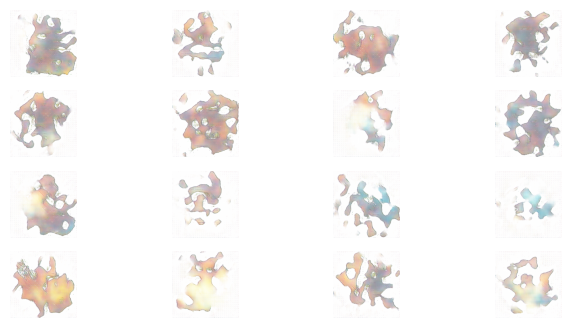

 20%|██        | 80/400 [06:59<30:04,  5.64s/it]

Time for epoch 80 is 6.738192319869995 sec
Training started with  epoch 81 with 7 batches..


 20%|██        | 81/400 [07:04<29:21,  5.52s/it]

Losses after epoch    81: generator 0.113, discriminator 4.812,               real_score 100.00%, fake_score 92.18%
Time for epoch 81 is 5.239344120025635 sec
Training started with  epoch 82 with 7 batches..


 20%|██        | 82/400 [07:09<28:37,  5.40s/it]

Losses after epoch    82: generator 17.588, discriminator 0.294,               real_score 84.86%, fake_score 0.00%
Time for epoch 82 is 5.1170690059661865 sec
Training started with  epoch 83 with 7 batches..


 21%|██        | 83/400 [07:14<28:07,  5.32s/it]

Losses after epoch    83: generator 7.880, discriminator 0.027,               real_score 99.39%, fake_score 1.40%
Time for epoch 83 is 5.1417396068573 sec
Training started with  epoch 84 with 7 batches..


 21%|██        | 84/400 [07:19<27:45,  5.27s/it]

Losses after epoch    84: generator 7.628, discriminator 0.023,               real_score 99.12%, fake_score 1.19%
Time for epoch 84 is 5.147665500640869 sec
Training started with  epoch 85 with 7 batches..


 21%|██▏       | 85/400 [07:24<27:31,  5.24s/it]

Losses after epoch    85: generator 4.981, discriminator 0.124,               real_score 99.70%, fake_score 7.45%
Time for epoch 85 is 5.174448251724243 sec
Training started with  epoch 86 with 7 batches..


 22%|██▏       | 86/400 [07:30<27:20,  5.22s/it]

Losses after epoch    86: generator 7.301, discriminator 0.016,               real_score 99.23%, fake_score 0.81%
Time for epoch 86 is 5.168366432189941 sec
Training started with  epoch 87 with 7 batches..


 22%|██▏       | 87/400 [07:35<27:08,  5.20s/it]

Losses after epoch    87: generator 6.350, discriminator 0.038,               real_score 99.11%, fake_score 2.41%
Time for epoch 87 is 5.147129774093628 sec
Training started with  epoch 88 with 7 batches..


 22%|██▏       | 88/400 [07:40<27:09,  5.22s/it]

Losses after epoch    88: generator 6.995, discriminator 0.053,               real_score 97.85%, fake_score 2.03%
Time for epoch 88 is 5.258146286010742 sec
Training started with  epoch 89 with 7 batches..


 22%|██▏       | 89/400 [07:45<26:56,  5.20s/it]

Losses after epoch    89: generator 5.420, discriminator 0.042,               real_score 99.43%, fake_score 3.12%
Time for epoch 89 is 5.140930414199829 sec
Training started with  epoch 90 with 7 batches..
Losses after epoch    90: generator 3.851, discriminator 0.172,               real_score 99.83%, fake_score 10.81%


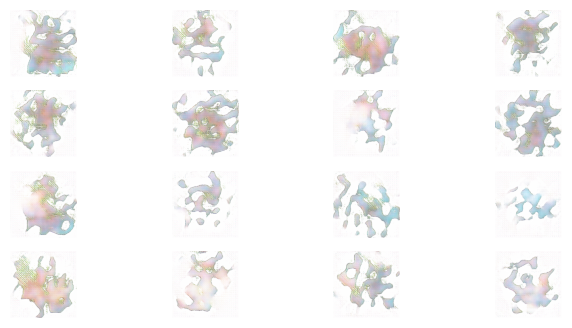

 22%|██▎       | 90/400 [07:51<28:27,  5.51s/it]

Time for epoch 90 is 6.23519229888916 sec
Training started with  epoch 91 with 7 batches..


 23%|██▎       | 91/400 [07:57<27:48,  5.40s/it]

Losses after epoch    91: generator 4.722, discriminator 0.105,               real_score 99.81%, fake_score 7.56%
Time for epoch 91 is 5.142609119415283 sec
Training started with  epoch 92 with 7 batches..


 23%|██▎       | 92/400 [08:02<27:20,  5.33s/it]

Losses after epoch    92: generator 5.369, discriminator 0.079,               real_score 99.17%, fake_score 5.17%
Time for epoch 92 is 5.157153129577637 sec
Training started with  epoch 93 with 7 batches..


 23%|██▎       | 93/400 [08:07<27:11,  5.31s/it]

Losses after epoch    93: generator 6.183, discriminator 0.054,               real_score 98.69%, fake_score 3.12%
Time for epoch 93 is 5.280867576599121 sec
Training started with  epoch 94 with 7 batches..


 24%|██▎       | 94/400 [08:12<26:50,  5.26s/it]

Losses after epoch    94: generator 2.972, discriminator 0.357,               real_score 99.87%, fake_score 21.39%
Time for epoch 94 is 5.144754409790039 sec
Training started with  epoch 95 with 7 batches..


 24%|██▍       | 95/400 [08:17<26:43,  5.26s/it]

Losses after epoch    95: generator 4.833, discriminator 0.134,               real_score 99.78%, fake_score 8.36%
Time for epoch 95 is 5.232672691345215 sec
Training started with  epoch 96 with 7 batches..


 24%|██▍       | 96/400 [08:23<26:52,  5.30s/it]

Losses after epoch    96: generator 4.475, discriminator 0.117,               real_score 99.15%, fake_score 8.03%
Time for epoch 96 is 5.410375118255615 sec
Training started with  epoch 97 with 7 batches..


 24%|██▍       | 97/400 [08:28<26:44,  5.29s/it]

Losses after epoch    97: generator 4.700, discriminator 0.095,               real_score 99.57%, fake_score 5.94%
Time for epoch 97 is 5.268810749053955 sec
Training started with  epoch 98 with 7 batches..


 24%|██▍       | 98/400 [08:33<26:26,  5.25s/it]

Losses after epoch    98: generator 4.515, discriminator 0.102,               real_score 98.90%, fake_score 7.09%
Time for epoch 98 is 5.160170555114746 sec
Training started with  epoch 99 with 7 batches..


 25%|██▍       | 99/400 [08:38<26:11,  5.22s/it]

Losses after epoch    99: generator 4.098, discriminator 0.134,               real_score 99.63%, fake_score 8.75%
Time for epoch 99 is 5.142404556274414 sec
Training started with  epoch 100 with 7 batches..
Losses after epoch   100: generator 5.272, discriminator 0.032,               real_score 99.40%, fake_score 2.44%


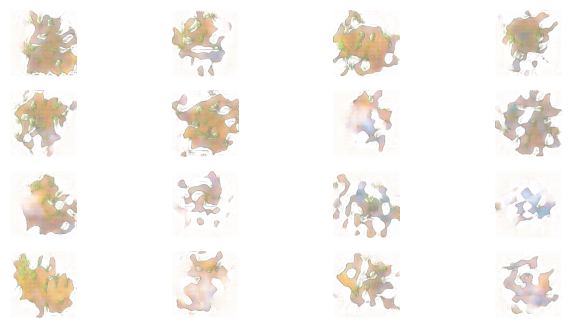

 25%|██▌       | 100/400 [08:45<27:35,  5.52s/it]

Time for epoch 100 is 6.213356971740723 sec
Training started with  epoch 101 with 7 batches..


 25%|██▌       | 101/400 [08:50<26:57,  5.41s/it]

Losses after epoch   101: generator 5.967, discriminator 0.036,               real_score 99.09%, fake_score 2.17%
Time for epoch 101 is 5.153398513793945 sec
Training started with  epoch 102 with 7 batches..


 26%|██▌       | 102/400 [08:55<26:28,  5.33s/it]

Losses after epoch   102: generator 5.010, discriminator 0.077,               real_score 99.46%, fake_score 5.39%
Time for epoch 102 is 5.139228105545044 sec
Training started with  epoch 103 with 7 batches..


 26%|██▌       | 103/400 [09:00<26:05,  5.27s/it]

Losses after epoch   103: generator 5.385, discriminator 0.068,               real_score 99.67%, fake_score 4.07%
Time for epoch 103 is 5.138922691345215 sec
Training started with  epoch 104 with 7 batches..


 26%|██▌       | 104/400 [09:05<25:57,  5.26s/it]

Losses after epoch   104: generator 5.152, discriminator 0.063,               real_score 98.73%, fake_score 4.04%
Time for epoch 104 is 5.234537363052368 sec
Training started with  epoch 105 with 7 batches..


 26%|██▋       | 105/400 [09:10<25:43,  5.23s/it]

Losses after epoch   105: generator 3.879, discriminator 0.106,               real_score 99.68%, fake_score 8.27%
Time for epoch 105 is 5.15983247756958 sec
Training started with  epoch 106 with 7 batches..


 26%|██▋       | 106/400 [09:16<25:30,  5.21s/it]

Losses after epoch   106: generator 5.735, discriminator 0.041,               real_score 98.32%, fake_score 2.01%
Time for epoch 106 is 5.146757364273071 sec
Training started with  epoch 107 with 7 batches..


 27%|██▋       | 107/400 [09:21<25:19,  5.19s/it]

Losses after epoch   107: generator 6.639, discriminator 0.038,               real_score 97.45%, fake_score 1.03%
Time for epoch 107 is 5.136072397232056 sec
Training started with  epoch 108 with 7 batches..


 27%|██▋       | 108/400 [09:26<25:12,  5.18s/it]

Losses after epoch   108: generator 1.882, discriminator 0.697,               real_score 99.97%, fake_score 33.94%
Time for epoch 108 is 5.167021751403809 sec
Training started with  epoch 109 with 7 batches..


 27%|██▋       | 109/400 [09:31<25:15,  5.21s/it]

Losses after epoch   109: generator 17.104, discriminator 2.460,               real_score 19.39%, fake_score 0.00%
Time for epoch 109 is 5.2643022537231445 sec
Training started with  epoch 110 with 7 batches..
Losses after epoch   110: generator 3.225, discriminator 0.297,               real_score 99.99%, fake_score 18.25%


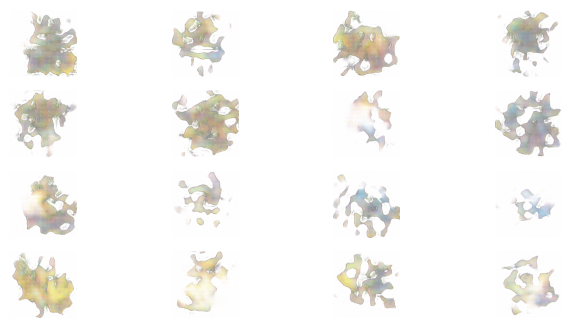

 28%|██▊       | 110/400 [09:38<27:56,  5.78s/it]

Time for epoch 110 is 7.117349624633789 sec
Training started with  epoch 111 with 7 batches..


 28%|██▊       | 111/400 [09:44<27:05,  5.62s/it]

Losses after epoch   111: generator 3.624, discriminator 0.249,               real_score 99.95%, fake_score 14.19%
Time for epoch 111 is 5.250626802444458 sec
Training started with  epoch 112 with 7 batches..


 28%|██▊       | 112/400 [09:49<26:17,  5.48s/it]

Losses after epoch   112: generator 5.322, discriminator 0.048,               real_score 99.78%, fake_score 3.97%
Time for epoch 112 is 5.1362833976745605 sec
Training started with  epoch 113 with 7 batches..


 28%|██▊       | 113/400 [09:54<25:43,  5.38s/it]

Losses after epoch   113: generator 2.026, discriminator 0.546,               real_score 99.97%, fake_score 30.74%
Time for epoch 113 is 5.1423280239105225 sec
Training started with  epoch 114 with 7 batches..


 28%|██▊       | 114/400 [09:59<25:17,  5.30s/it]

Losses after epoch   114: generator 6.871, discriminator 0.027,               real_score 98.69%, fake_score 1.13%
Time for epoch 114 is 5.131983041763306 sec
Training started with  epoch 115 with 7 batches..


 29%|██▉       | 115/400 [10:04<24:57,  5.26s/it]

Losses after epoch   115: generator 5.097, discriminator 0.086,               real_score 99.16%, fake_score 5.79%
Time for epoch 115 is 5.1403489112854 sec
Training started with  epoch 116 with 7 batches..


 29%|██▉       | 116/400 [10:09<24:43,  5.22s/it]

Losses after epoch   116: generator 3.170, discriminator 0.277,               real_score 99.95%, fake_score 17.07%
Time for epoch 116 is 5.14442777633667 sec
Training started with  epoch 117 with 7 batches..


 29%|██▉       | 117/400 [10:14<24:31,  5.20s/it]

Losses after epoch   117: generator 4.732, discriminator 0.082,               real_score 99.79%, fake_score 5.49%
Time for epoch 117 is 5.1393187046051025 sec
Training started with  epoch 118 with 7 batches..


 30%|██▉       | 118/400 [10:20<24:31,  5.22s/it]

Losses after epoch   118: generator 4.882, discriminator 0.113,               real_score 99.05%, fake_score 6.99%
Time for epoch 118 is 5.259216070175171 sec
Training started with  epoch 119 with 7 batches..


 30%|██▉       | 119/400 [10:25<24:19,  5.19s/it]

Losses after epoch   119: generator 4.898, discriminator 0.087,               real_score 99.00%, fake_score 5.76%
Time for epoch 119 is 5.138598918914795 sec
Training started with  epoch 120 with 7 batches..
Losses after epoch   120: generator 5.934, discriminator 0.025,               real_score 99.25%, fake_score 1.56%


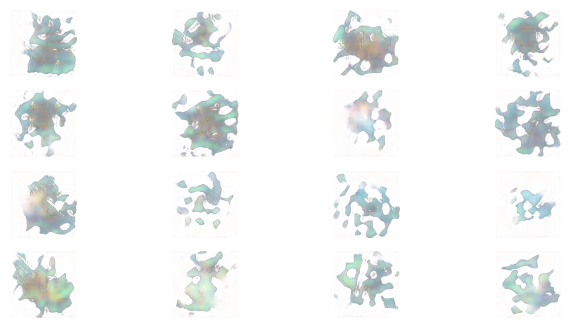

 30%|███       | 120/400 [10:31<25:44,  5.52s/it]

Time for epoch 120 is 6.2645041942596436 sec
Training started with  epoch 121 with 7 batches..


 30%|███       | 121/400 [10:36<25:08,  5.41s/it]

Losses after epoch   121: generator 4.669, discriminator 0.105,               real_score 99.59%, fake_score 7.04%
Time for epoch 121 is 5.148284912109375 sec
Training started with  epoch 122 with 7 batches..


 30%|███       | 122/400 [10:41<24:41,  5.33s/it]

Losses after epoch   122: generator 5.949, discriminator 0.087,               real_score 98.78%, fake_score 3.89%
Time for epoch 122 is 5.143498182296753 sec
Training started with  epoch 123 with 7 batches..


 31%|███       | 123/400 [10:46<24:19,  5.27s/it]

Losses after epoch   123: generator 4.435, discriminator 0.088,               real_score 99.60%, fake_score 6.70%
Time for epoch 123 is 5.126047611236572 sec
Training started with  epoch 124 with 7 batches..


 31%|███       | 124/400 [10:52<24:03,  5.23s/it]

Losses after epoch   124: generator 4.839, discriminator 0.096,               real_score 97.87%, fake_score 4.78%
Time for epoch 124 is 5.136979818344116 sec
Training started with  epoch 125 with 7 batches..


 31%|███▏      | 125/400 [10:57<23:58,  5.23s/it]

Losses after epoch   125: generator 6.199, discriminator 0.045,               real_score 97.78%, fake_score 2.03%
Time for epoch 125 is 5.235149145126343 sec
Training started with  epoch 126 with 7 batches..


 32%|███▏      | 126/400 [11:02<23:46,  5.20s/it]

Losses after epoch   126: generator 4.345, discriminator 0.108,               real_score 99.50%, fake_score 7.65%
Time for epoch 126 is 5.139506816864014 sec
Training started with  epoch 127 with 7 batches..


 32%|███▏      | 127/400 [11:07<23:41,  5.21s/it]

Losses after epoch   127: generator 5.858, discriminator 0.036,               real_score 98.49%, fake_score 1.91%
Time for epoch 127 is 5.206634521484375 sec
Training started with  epoch 128 with 7 batches..


 32%|███▏      | 128/400 [11:12<23:33,  5.20s/it]

Losses after epoch   128: generator 6.151, discriminator 0.071,               real_score 96.04%, fake_score 1.56%
Time for epoch 128 is 5.16981053352356 sec
Training started with  epoch 129 with 7 batches..


 32%|███▏      | 129/400 [11:18<23:25,  5.18s/it]

Losses after epoch   129: generator 0.043, discriminator 7.052,               real_score 100.00%, fake_score 98.04%
Time for epoch 129 is 5.157836198806763 sec
Training started with  epoch 130 with 7 batches..
Losses after epoch   130: generator 19.739, discriminator 4.421,               real_score 11.80%, fake_score 0.00%


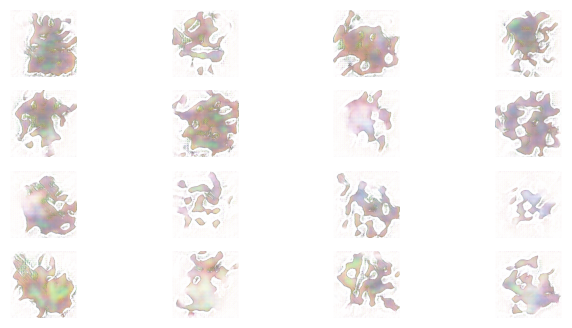

 32%|███▎      | 130/400 [11:24<24:47,  5.51s/it]

Time for epoch 130 is 6.269980430603027 sec
Training started with  epoch 131 with 7 batches..


 33%|███▎      | 131/400 [11:29<24:17,  5.42s/it]

Losses after epoch   131: generator 0.128, discriminator 4.996,               real_score 100.00%, fake_score 91.42%
Time for epoch 131 is 5.19426417350769 sec
Training started with  epoch 132 with 7 batches..


 33%|███▎      | 132/400 [11:34<23:47,  5.33s/it]

Losses after epoch   132: generator 5.446, discriminator 0.138,               real_score 95.67%, fake_score 5.32%
Time for epoch 132 is 5.116577625274658 sec
Training started with  epoch 133 with 7 batches..


 33%|███▎      | 133/400 [11:39<23:27,  5.27s/it]

Losses after epoch   133: generator 6.504, discriminator 0.072,               real_score 96.58%, fake_score 2.56%
Time for epoch 133 is 5.142420530319214 sec
Training started with  epoch 134 with 7 batches..


 34%|███▎      | 134/400 [11:45<23:20,  5.27s/it]

Losses after epoch   134: generator 6.271, discriminator 0.060,               real_score 98.90%, fake_score 3.35%
Time for epoch 134 is 5.2432379722595215 sec
Training started with  epoch 135 with 7 batches..


 34%|███▍      | 135/400 [11:50<23:04,  5.22s/it]

Losses after epoch   135: generator 5.082, discriminator 0.131,               real_score 99.33%, fake_score 6.89%
Time for epoch 135 is 5.128413200378418 sec
Training started with  epoch 136 with 7 batches..


 34%|███▍      | 136/400 [11:55<22:52,  5.20s/it]

Losses after epoch   136: generator 7.807, discriminator 0.077,               real_score 95.21%, fake_score 1.66%
Time for epoch 136 is 5.137012720108032 sec
Training started with  epoch 137 with 7 batches..


 34%|███▍      | 137/400 [12:00<22:41,  5.18s/it]

Losses after epoch   137: generator 6.072, discriminator 0.064,               real_score 97.60%, fake_score 3.12%
Time for epoch 137 is 5.122920751571655 sec
Training started with  epoch 138 with 7 batches..


 34%|███▍      | 138/400 [12:05<22:33,  5.16s/it]

Losses after epoch   138: generator 5.989, discriminator 0.051,               real_score 97.97%, fake_score 2.25%
Time for epoch 138 is 5.136065721511841 sec
Training started with  epoch 139 with 7 batches..


 35%|███▍      | 139/400 [12:10<22:24,  5.15s/it]

Losses after epoch   139: generator 13.423, discriminator 1.334,               real_score 44.32%, fake_score 0.00%
Time for epoch 139 is 5.12092399597168 sec
Training started with  epoch 140 with 7 batches..
Losses after epoch   140: generator 5.232, discriminator 0.090,               real_score 99.94%, fake_score 6.57%


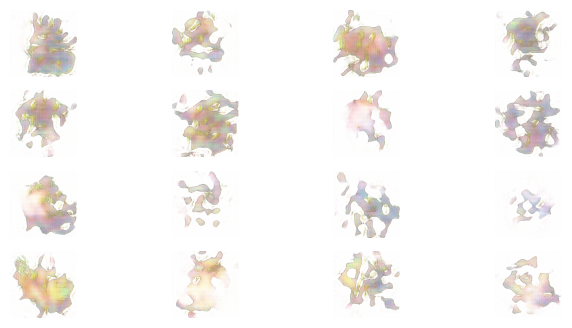

 35%|███▌      | 140/400 [12:17<24:17,  5.60s/it]

Time for epoch 140 is 6.650524377822876 sec
Training started with  epoch 141 with 7 batches..


 35%|███▌      | 141/400 [12:22<23:46,  5.51s/it]

Losses after epoch   141: generator 4.632, discriminator 0.118,               real_score 99.96%, fake_score 8.00%
Time for epoch 141 is 5.280681371688843 sec
Training started with  epoch 142 with 7 batches..


 36%|███▌      | 142/400 [12:27<23:12,  5.40s/it]

Losses after epoch   142: generator 3.417, discriminator 0.223,               real_score 99.99%, fake_score 13.81%
Time for epoch 142 is 5.1339263916015625 sec
Training started with  epoch 143 with 7 batches..


 36%|███▌      | 143/400 [12:32<22:47,  5.32s/it]

Losses after epoch   143: generator 4.383, discriminator 0.181,               real_score 99.93%, fake_score 11.79%
Time for epoch 143 is 5.139979362487793 sec
Training started with  epoch 144 with 7 batches..


 36%|███▌      | 144/400 [12:38<22:28,  5.27s/it]

Losses after epoch   144: generator 6.197, discriminator 0.043,               real_score 99.10%, fake_score 2.35%
Time for epoch 144 is 5.1462132930755615 sec
Training started with  epoch 145 with 7 batches..


 36%|███▋      | 145/400 [12:43<22:15,  5.24s/it]

Losses after epoch   145: generator 3.048, discriminator 0.375,               real_score 99.71%, fake_score 18.22%
Time for epoch 145 is 5.165785551071167 sec
Training started with  epoch 146 with 7 batches..


 36%|███▋      | 146/400 [12:48<22:04,  5.21s/it]

Losses after epoch   146: generator 4.887, discriminator 0.095,               real_score 99.32%, fake_score 6.42%
Time for epoch 146 is 5.1516687870025635 sec
Training started with  epoch 147 with 7 batches..


 37%|███▋      | 147/400 [12:53<21:55,  5.20s/it]

Losses after epoch   147: generator 3.935, discriminator 0.129,               real_score 99.58%, fake_score 8.70%
Time for epoch 147 is 5.161940336227417 sec
Training started with  epoch 148 with 7 batches..


 37%|███▋      | 148/400 [12:58<21:52,  5.21s/it]

Losses after epoch   148: generator 7.808, discriminator 0.117,               real_score 93.90%, fake_score 0.29%
Time for epoch 148 is 5.231716871261597 sec
Training started with  epoch 149 with 7 batches..


 37%|███▋      | 149/400 [13:03<21:43,  5.19s/it]

Losses after epoch   149: generator 4.026, discriminator 0.148,               real_score 99.58%, fake_score 9.59%
Time for epoch 149 is 5.149312973022461 sec
Training started with  epoch 150 with 7 batches..
Losses after epoch   150: generator 5.450, discriminator 0.052,               real_score 99.69%, fake_score 4.06%


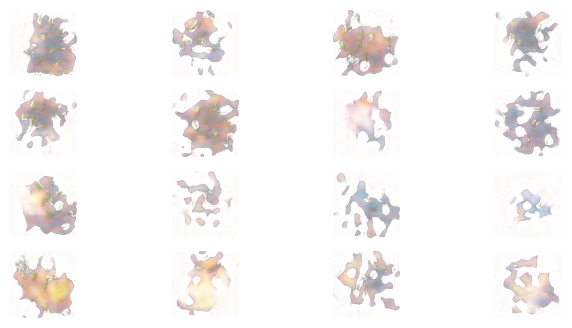

 38%|███▊      | 150/400 [13:10<23:23,  5.61s/it]

Time for epoch 150 is 6.59170937538147 sec
Training started with  epoch 151 with 7 batches..


 38%|███▊      | 151/400 [13:15<22:42,  5.47s/it]

Losses after epoch   151: generator 5.707, discriminator 0.052,               real_score 99.19%, fake_score 3.28%
Time for epoch 151 is 5.134802579879761 sec
Training started with  epoch 152 with 7 batches..


 38%|███▊      | 152/400 [13:20<22:11,  5.37s/it]

Losses after epoch   152: generator 4.320, discriminator 0.060,               real_score 99.77%, fake_score 5.23%
Time for epoch 152 is 5.134978294372559 sec
Training started with  epoch 153 with 7 batches..


 38%|███▊      | 153/400 [13:25<21:49,  5.30s/it]

Losses after epoch   153: generator 5.202, discriminator 0.060,               real_score 98.26%, fake_score 3.56%
Time for epoch 153 is 5.1403114795684814 sec
Training started with  epoch 154 with 7 batches..


 38%|███▊      | 154/400 [13:31<21:32,  5.25s/it]

Losses after epoch   154: generator 2.214, discriminator 0.471,               real_score 99.96%, fake_score 27.36%
Time for epoch 154 is 5.138900518417358 sec
Training started with  epoch 155 with 7 batches..


 39%|███▉      | 155/400 [13:36<21:22,  5.24s/it]

Losses after epoch   155: generator 17.494, discriminator 2.400,               real_score 25.91%, fake_score 0.00%
Time for epoch 155 is 5.192870616912842 sec
Training started with  epoch 156 with 7 batches..


 39%|███▉      | 156/400 [13:41<21:11,  5.21s/it]

Losses after epoch   156: generator 2.221, discriminator 1.046,               real_score 100.00%, fake_score 36.76%
Time for epoch 156 is 5.145907878875732 sec
Training started with  epoch 157 with 7 batches..


 39%|███▉      | 157/400 [13:46<21:01,  5.19s/it]

Losses after epoch   157: generator 0.019, discriminator 8.029,               real_score 100.00%, fake_score 98.50%
Time for epoch 157 is 5.14971137046814 sec
Training started with  epoch 158 with 7 batches..


 40%|███▉      | 158/400 [13:51<20:53,  5.18s/it]

Losses after epoch   158: generator 0.068, discriminator 7.757,               real_score 100.00%, fake_score 95.86%
Time for epoch 158 is 5.149402141571045 sec
Training started with  epoch 159 with 7 batches..


 40%|███▉      | 159/400 [13:56<20:45,  5.17s/it]

Losses after epoch   159: generator 5.544, discriminator 0.132,               real_score 96.22%, fake_score 4.46%
Time for epoch 159 is 5.143846035003662 sec
Training started with  epoch 160 with 7 batches..
Losses after epoch   160: generator 2.110, discriminator 0.752,               real_score 100.00%, fake_score 34.02%


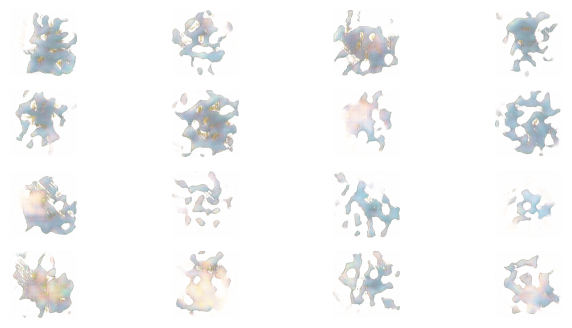

 40%|████      | 160/400 [14:03<21:54,  5.48s/it]

Time for epoch 160 is 6.198708534240723 sec
Training started with  epoch 161 with 7 batches..


 40%|████      | 161/400 [14:08<21:27,  5.39s/it]

Losses after epoch   161: generator 22.105, discriminator 5.721,               real_score 2.67%, fake_score 0.00%
Time for epoch 161 is 5.171978712081909 sec
Training started with  epoch 162 with 7 batches..


 40%|████      | 162/400 [14:13<21:07,  5.33s/it]

Losses after epoch   162: generator 8.073, discriminator 0.131,               real_score 93.08%, fake_score 0.45%
Time for epoch 162 is 5.178431749343872 sec
Training started with  epoch 163 with 7 batches..


 41%|████      | 163/400 [14:18<20:49,  5.27s/it]

Losses after epoch   163: generator 1.280, discriminator 1.455,               real_score 99.94%, fake_score 52.79%
Time for epoch 163 is 5.141008377075195 sec
Training started with  epoch 164 with 7 batches..


 41%|████      | 164/400 [14:23<20:40,  5.25s/it]

Losses after epoch   164: generator 18.368, discriminator 0.436,               real_score 79.84%, fake_score 0.00%
Time for epoch 164 is 5.2089478969573975 sec
Training started with  epoch 165 with 7 batches..


 41%|████▏     | 165/400 [14:28<20:26,  5.22s/it]

Losses after epoch   165: generator 7.325, discriminator 0.062,               real_score 97.29%, fake_score 2.10%
Time for epoch 165 is 5.140020370483398 sec
Training started with  epoch 166 with 7 batches..


 42%|████▏     | 166/400 [14:34<20:15,  5.20s/it]

Losses after epoch   166: generator 12.482, discriminator 0.291,               real_score 83.68%, fake_score 0.02%
Time for epoch 166 is 5.137665510177612 sec
Training started with  epoch 167 with 7 batches..


 42%|████▏     | 167/400 [14:39<20:06,  5.18s/it]

Losses after epoch   167: generator 6.466, discriminator 0.137,               real_score 91.59%, fake_score 2.34%
Time for epoch 167 is 5.137216329574585 sec
Training started with  epoch 168 with 7 batches..


 42%|████▏     | 168/400 [14:44<19:58,  5.17s/it]

Losses after epoch   168: generator 6.668, discriminator 0.059,               real_score 97.50%, fake_score 2.65%
Time for epoch 168 is 5.140163421630859 sec
Training started with  epoch 169 with 7 batches..


 42%|████▏     | 169/400 [14:49<19:59,  5.19s/it]

Losses after epoch   169: generator 4.067, discriminator 0.175,               real_score 99.42%, fake_score 11.37%
Time for epoch 169 is 5.23960018157959 sec
Training started with  epoch 170 with 7 batches..
Losses after epoch   170: generator 9.194, discriminator 0.059,               real_score 95.48%, fake_score 0.30%


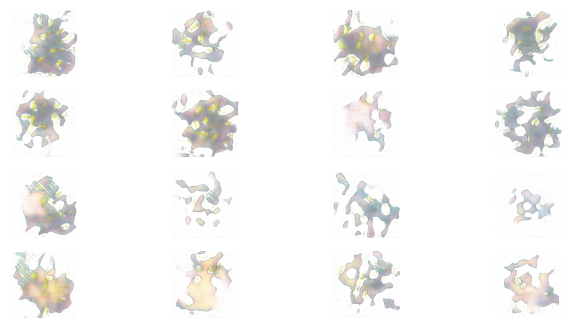

 42%|████▎     | 170/400 [14:56<21:29,  5.61s/it]

Time for epoch 170 is 6.578169584274292 sec
Training started with  epoch 171 with 7 batches..


 43%|████▎     | 171/400 [15:01<21:02,  5.51s/it]

Losses after epoch   171: generator 5.035, discriminator 0.121,               real_score 99.42%, fake_score 7.45%
Time for epoch 171 is 5.2835588455200195 sec
Training started with  epoch 172 with 7 batches..


 43%|████▎     | 172/400 [15:06<20:30,  5.40s/it]

Losses after epoch   172: generator 7.095, discriminator 0.044,               real_score 96.95%, fake_score 0.66%
Time for epoch 172 is 5.129497289657593 sec
Training started with  epoch 173 with 7 batches..


 43%|████▎     | 173/400 [15:11<20:08,  5.32s/it]

Losses after epoch   173: generator 10.550, discriminator 0.520,               real_score 71.75%, fake_score 0.06%
Time for epoch 173 is 5.146774053573608 sec
Training started with  epoch 174 with 7 batches..


 44%|████▎     | 174/400 [15:16<19:50,  5.27s/it]

Losses after epoch   174: generator 5.967, discriminator 0.081,               real_score 99.56%, fake_score 4.76%
Time for epoch 174 is 5.1431944370269775 sec
Training started with  epoch 175 with 7 batches..


 44%|████▍     | 175/400 [15:22<19:36,  5.23s/it]

Losses after epoch   175: generator 5.462, discriminator 0.065,               real_score 99.51%, fake_score 4.77%
Time for epoch 175 is 5.136620759963989 sec
Training started with  epoch 176 with 7 batches..


 44%|████▍     | 176/400 [15:27<19:26,  5.21s/it]

Losses after epoch   176: generator 6.606, discriminator 0.027,               real_score 99.16%, fake_score 1.59%
Time for epoch 176 is 5.1567206382751465 sec
Training started with  epoch 177 with 7 batches..


 44%|████▍     | 177/400 [15:32<19:17,  5.19s/it]

Losses after epoch   177: generator 5.368, discriminator 0.082,               real_score 99.32%, fake_score 4.83%
Time for epoch 177 is 5.1410627365112305 sec
Training started with  epoch 178 with 7 batches..


 44%|████▍     | 178/400 [15:37<19:12,  5.19s/it]

Losses after epoch   178: generator 6.707, discriminator 0.034,               real_score 98.64%, fake_score 1.63%
Time for epoch 178 is 5.1934380531311035 sec
Training started with  epoch 179 with 7 batches..


 45%|████▍     | 179/400 [15:42<19:04,  5.18s/it]

Losses after epoch   179: generator 6.099, discriminator 0.042,               real_score 98.87%, fake_score 2.52%
Time for epoch 179 is 5.1418328285217285 sec
Training started with  epoch 180 with 7 batches..
Losses after epoch   180: generator 6.619, discriminator 0.051,               real_score 97.64%, fake_score 1.39%


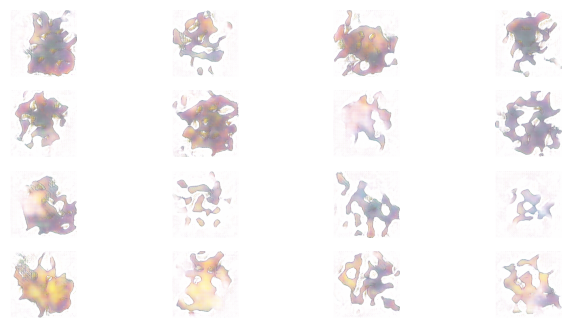

 45%|████▌     | 180/400 [15:48<20:07,  5.49s/it]

Time for epoch 180 is 6.21185827255249 sec
Training started with  epoch 181 with 7 batches..


 45%|████▌     | 181/400 [15:54<19:40,  5.39s/it]

Losses after epoch   181: generator 4.932, discriminator 0.085,               real_score 99.37%, fake_score 5.91%
Time for epoch 181 is 5.160918712615967 sec
Training started with  epoch 182 with 7 batches..


 46%|████▌     | 182/400 [15:59<19:19,  5.32s/it]

Losses after epoch   182: generator 6.742, discriminator 0.056,               real_score 96.21%, fake_score 0.73%
Time for epoch 182 is 5.140456676483154 sec
Training started with  epoch 183 with 7 batches..


 46%|████▌     | 183/400 [16:04<19:02,  5.26s/it]

Losses after epoch   183: generator 4.591, discriminator 0.082,               real_score 98.78%, fake_score 5.27%
Time for epoch 183 is 5.138379096984863 sec
Training started with  epoch 184 with 7 batches..


 46%|████▌     | 184/400 [16:09<18:49,  5.23s/it]

Losses after epoch   184: generator 4.919, discriminator 0.057,               real_score 99.84%, fake_score 4.58%
Time for epoch 184 is 5.142527341842651 sec
Training started with  epoch 185 with 7 batches..


 46%|████▋     | 185/400 [16:14<18:45,  5.23s/it]

Losses after epoch   185: generator 4.394, discriminator 0.129,               real_score 99.23%, fake_score 8.37%
Time for epoch 185 is 5.243506669998169 sec
Training started with  epoch 186 with 7 batches..


 46%|████▋     | 186/400 [16:19<18:34,  5.21s/it]

Losses after epoch   186: generator 5.212, discriminator 0.093,               real_score 98.41%, fake_score 5.55%
Time for epoch 186 is 5.147798299789429 sec
Training started with  epoch 187 with 7 batches..


 47%|████▋     | 187/400 [16:25<18:25,  5.19s/it]

Losses after epoch   187: generator 4.969, discriminator 0.066,               real_score 99.69%, fake_score 5.02%
Time for epoch 187 is 5.135761022567749 sec
Training started with  epoch 188 with 7 batches..


 47%|████▋     | 188/400 [16:30<18:18,  5.18s/it]

Losses after epoch   188: generator 5.720, discriminator 0.037,               real_score 98.95%, fake_score 2.36%
Time for epoch 188 is 5.1671833992004395 sec
Training started with  epoch 189 with 7 batches..


 47%|████▋     | 189/400 [16:35<18:12,  5.18s/it]

Losses after epoch   189: generator 4.706, discriminator 0.099,               real_score 98.96%, fake_score 6.04%
Time for epoch 189 is 5.160740852355957 sec
Training started with  epoch 190 with 7 batches..
Losses after epoch   190: generator 5.867, discriminator 0.047,               real_score 98.34%, fake_score 2.52%


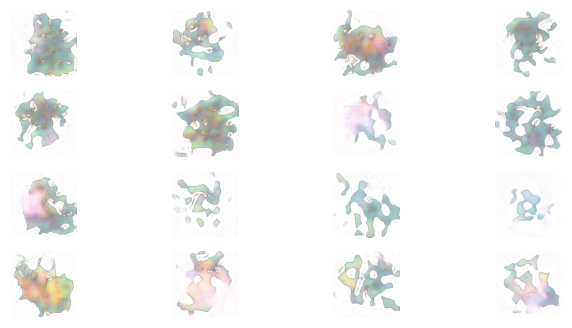

 48%|████▊     | 190/400 [16:41<19:16,  5.51s/it]

Time for epoch 190 is 6.282963514328003 sec
Training started with  epoch 191 with 7 batches..


 48%|████▊     | 191/400 [16:46<18:51,  5.41s/it]

Losses after epoch   191: generator 4.844, discriminator 0.111,               real_score 99.44%, fake_score 5.88%
Time for epoch 191 is 5.18421196937561 sec
Training started with  epoch 192 with 7 batches..


 48%|████▊     | 192/400 [16:52<18:35,  5.36s/it]

Losses after epoch   192: generator 5.092, discriminator 0.071,               real_score 99.58%, fake_score 4.82%
Time for epoch 192 is 5.244048595428467 sec
Training started with  epoch 193 with 7 batches..


 48%|████▊     | 193/400 [16:57<18:17,  5.30s/it]

Losses after epoch   193: generator 3.728, discriminator 0.218,               real_score 99.93%, fake_score 12.48%
Time for epoch 193 is 5.152650356292725 sec
Training started with  epoch 194 with 7 batches..


 48%|████▊     | 194/400 [17:02<18:02,  5.25s/it]

Losses after epoch   194: generator 5.225, discriminator 0.104,               real_score 97.95%, fake_score 5.02%
Time for epoch 194 is 5.143612623214722 sec
Training started with  epoch 195 with 7 batches..


 49%|████▉     | 195/400 [17:07<17:50,  5.22s/it]

Losses after epoch   195: generator 4.760, discriminator 0.061,               real_score 99.36%, fake_score 4.46%
Time for epoch 195 is 5.139583349227905 sec
Training started with  epoch 196 with 7 batches..


 49%|████▉     | 196/400 [17:12<17:40,  5.20s/it]

Losses after epoch   196: generator 4.393, discriminator 0.089,               real_score 99.58%, fake_score 6.38%
Time for epoch 196 is 5.138517618179321 sec
Training started with  epoch 197 with 7 batches..


 49%|████▉     | 197/400 [17:17<17:30,  5.17s/it]

Losses after epoch   197: generator 4.819, discriminator 0.078,               real_score 99.82%, fake_score 5.80%
Time for epoch 197 is 5.122320890426636 sec
Training started with  epoch 198 with 7 batches..


 50%|████▉     | 198/400 [17:22<17:23,  5.17s/it]

Losses after epoch   198: generator 4.407, discriminator 0.089,               real_score 99.65%, fake_score 5.92%
Time for epoch 198 is 5.145573854446411 sec
Training started with  epoch 199 with 7 batches..


 50%|████▉     | 199/400 [17:28<17:19,  5.17s/it]

Losses after epoch   199: generator 4.953, discriminator 0.060,               real_score 98.93%, fake_score 4.29%
Time for epoch 199 is 5.184874773025513 sec
Training started with  epoch 200 with 7 batches..
Losses after epoch   200: generator 8.134, discriminator 0.217,               real_score 84.60%, fake_score 0.29%


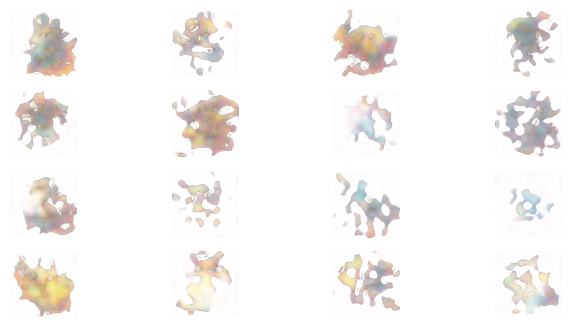

 50%|█████     | 200/400 [17:34<18:34,  5.57s/it]

Time for epoch 200 is 6.500694036483765 sec
Training started with  epoch 201 with 7 batches..


 50%|█████     | 201/400 [17:39<18:04,  5.45s/it]

Losses after epoch   201: generator 2.219, discriminator 0.552,               real_score 99.97%, fake_score 28.04%
Time for epoch 201 is 5.1651153564453125 sec
Training started with  epoch 202 with 7 batches..


 50%|█████     | 202/400 [17:44<17:40,  5.36s/it]

Losses after epoch   202: generator 6.027, discriminator 0.030,               real_score 98.89%, fake_score 1.68%
Time for epoch 202 is 5.136910915374756 sec
Training started with  epoch 203 with 7 batches..


 51%|█████     | 203/400 [17:50<17:22,  5.29s/it]

Losses after epoch   203: generator 4.947, discriminator 0.068,               real_score 98.09%, fake_score 3.90%
Time for epoch 203 is 5.137380123138428 sec
Training started with  epoch 204 with 7 batches..


 51%|█████     | 204/400 [17:55<17:08,  5.25s/it]

Losses after epoch   204: generator 4.607, discriminator 0.129,               real_score 99.74%, fake_score 7.76%
Time for epoch 204 is 5.1390252113342285 sec
Training started with  epoch 205 with 7 batches..


 51%|█████▏    | 205/400 [18:00<16:57,  5.22s/it]

Losses after epoch   205: generator 5.595, discriminator 0.051,               real_score 99.26%, fake_score 3.02%
Time for epoch 205 is 5.140743017196655 sec
Training started with  epoch 206 with 7 batches..


 52%|█████▏    | 206/400 [18:05<16:53,  5.22s/it]

Losses after epoch   206: generator 4.639, discriminator 0.072,               real_score 99.54%, fake_score 5.24%
Time for epoch 206 is 5.23563289642334 sec
Training started with  epoch 207 with 7 batches..


 52%|█████▏    | 207/400 [18:10<16:58,  5.28s/it]

Losses after epoch   207: generator 4.887, discriminator 0.075,               real_score 99.58%, fake_score 5.25%
Time for epoch 207 is 5.392401218414307 sec
Training started with  epoch 208 with 7 batches..


 52%|█████▏    | 208/400 [18:16<16:45,  5.24s/it]

Losses after epoch   208: generator 5.545, discriminator 0.042,               real_score 98.99%, fake_score 2.92%
Time for epoch 208 is 5.143909215927124 sec
Training started with  epoch 209 with 7 batches..


 52%|█████▏    | 209/400 [18:21<16:35,  5.21s/it]

Losses after epoch   209: generator 5.349, discriminator 0.061,               real_score 99.43%, fake_score 4.08%
Time for epoch 209 is 5.15847635269165 sec
Training started with  epoch 210 with 7 batches..
Losses after epoch   210: generator 4.681, discriminator 0.090,               real_score 98.88%, fake_score 5.70%


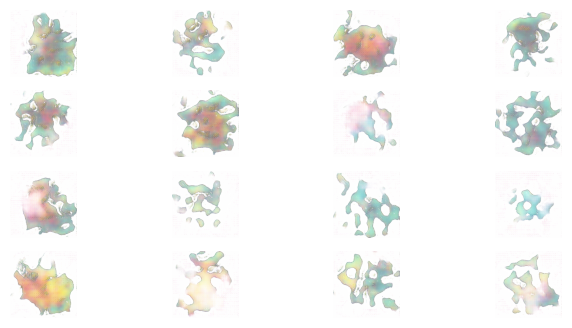

 52%|█████▎    | 210/400 [18:28<18:44,  5.92s/it]

Time for epoch 210 is 7.56574010848999 sec
Training started with  epoch 211 with 7 batches..


 53%|█████▎    | 211/400 [18:34<17:58,  5.71s/it]

Losses after epoch   211: generator 4.885, discriminator 0.093,               real_score 97.44%, fake_score 4.67%
Time for epoch 211 is 5.212935447692871 sec
Training started with  epoch 212 with 7 batches..


 53%|█████▎    | 212/400 [18:39<17:21,  5.54s/it]

Losses after epoch   212: generator 4.180, discriminator 0.116,               real_score 99.80%, fake_score 7.17%
Time for epoch 212 is 5.1513893604278564 sec
Training started with  epoch 213 with 7 batches..


 53%|█████▎    | 213/400 [18:44<16:53,  5.42s/it]

Losses after epoch   213: generator 4.143, discriminator 0.129,               real_score 99.86%, fake_score 9.33%
Time for epoch 213 is 5.137411832809448 sec
Training started with  epoch 214 with 7 batches..


 54%|█████▎    | 214/400 [18:49<16:32,  5.34s/it]

Losses after epoch   214: generator 0.214, discriminator 3.541,               real_score 100.00%, fake_score 85.64%
Time for epoch 214 is 5.1441497802734375 sec
Training started with  epoch 215 with 7 batches..


 54%|█████▍    | 215/400 [18:54<16:22,  5.31s/it]

Losses after epoch   215: generator 17.764, discriminator 2.127,               real_score 31.83%, fake_score 0.00%
Time for epoch 215 is 5.24781346321106 sec
Training started with  epoch 216 with 7 batches..


 54%|█████▍    | 216/400 [18:59<16:09,  5.27s/it]

Losses after epoch   216: generator 2.103, discriminator 0.819,               real_score 99.98%, fake_score 33.74%
Time for epoch 216 is 5.160727500915527 sec
Training started with  epoch 217 with 7 batches..


 54%|█████▍    | 217/400 [19:05<15:57,  5.23s/it]

Losses after epoch   217: generator 0.743, discriminator 2.050,               real_score 100.00%, fake_score 65.58%
Time for epoch 217 is 5.138990640640259 sec
Training started with  epoch 218 with 7 batches..


 55%|█████▍    | 218/400 [19:10<15:47,  5.21s/it]

Losses after epoch   218: generator 0.898, discriminator 2.165,               real_score 100.00%, fake_score 63.40%
Time for epoch 218 is 5.156521558761597 sec
Training started with  epoch 219 with 7 batches..


 55%|█████▍    | 219/400 [19:15<15:39,  5.19s/it]

Losses after epoch   219: generator 5.903, discriminator 0.040,               real_score 99.80%, fake_score 3.23%
Time for epoch 219 is 5.1571266651153564 sec
Training started with  epoch 220 with 7 batches..
Losses after epoch   220: generator 8.105, discriminator 0.165,               real_score 91.90%, fake_score 0.74%


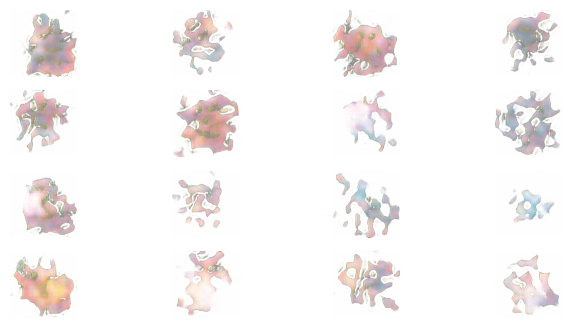

 55%|█████▌    | 220/400 [19:21<16:28,  5.49s/it]

Time for epoch 220 is 6.185723781585693 sec
Training started with  epoch 221 with 7 batches..


 55%|█████▌    | 221/400 [19:26<16:05,  5.39s/it]

Losses after epoch   221: generator 6.805, discriminator 0.092,               real_score 94.30%, fake_score 1.96%
Time for epoch 221 is 5.1611857414245605 sec
Training started with  epoch 222 with 7 batches..


 56%|█████▌    | 222/400 [19:31<15:50,  5.34s/it]

Losses after epoch   222: generator 5.873, discriminator 0.120,               real_score 96.28%, fake_score 5.24%
Time for epoch 222 is 5.2204883098602295 sec
Training started with  epoch 223 with 7 batches..


 56%|█████▌    | 223/400 [19:37<15:35,  5.28s/it]

Losses after epoch   223: generator 7.002, discriminator 0.057,               real_score 96.71%, fake_score 1.38%
Time for epoch 223 is 5.145491123199463 sec
Training started with  epoch 224 with 7 batches..


 56%|█████▌    | 224/400 [19:42<15:22,  5.24s/it]

Losses after epoch   224: generator 7.307, discriminator 0.084,               real_score 95.23%, fake_score 0.89%
Time for epoch 224 is 5.146012544631958 sec
Training started with  epoch 225 with 7 batches..


 56%|█████▋    | 225/400 [19:47<15:11,  5.21s/it]

Losses after epoch   225: generator 6.506, discriminator 0.060,               real_score 98.19%, fake_score 2.81%
Time for epoch 225 is 5.127185106277466 sec
Training started with  epoch 226 with 7 batches..


 56%|█████▋    | 226/400 [19:52<15:01,  5.18s/it]

Losses after epoch   226: generator 7.170, discriminator 0.074,               real_score 94.98%, fake_score 1.62%
Time for epoch 226 is 5.117650508880615 sec
Training started with  epoch 227 with 7 batches..


 57%|█████▋    | 227/400 [19:57<14:53,  5.16s/it]

Losses after epoch   227: generator 6.510, discriminator 0.077,               real_score 95.14%, fake_score 1.86%
Time for epoch 227 is 5.115046501159668 sec
Training started with  epoch 228 with 7 batches..


 57%|█████▋    | 228/400 [20:02<14:45,  5.15s/it]

Losses after epoch   228: generator 7.551, discriminator 0.113,               real_score 93.08%, fake_score 1.67%
Time for epoch 228 is 5.1166181564331055 sec
Training started with  epoch 229 with 7 batches..


 57%|█████▋    | 229/400 [20:07<14:44,  5.17s/it]

Losses after epoch   229: generator 6.575, discriminator 0.099,               real_score 97.76%, fake_score 3.02%
Time for epoch 229 is 5.220351457595825 sec
Training started with  epoch 230 with 7 batches..
Losses after epoch   230: generator 6.544, discriminator 0.049,               real_score 97.84%, fake_score 2.13%


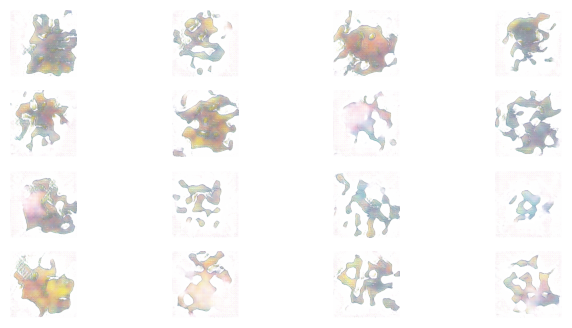

 57%|█████▊    | 230/400 [20:14<15:32,  5.49s/it]

Time for epoch 230 is 6.219835519790649 sec
Training started with  epoch 231 with 7 batches..


 58%|█████▊    | 231/400 [20:19<15:10,  5.39s/it]

Losses after epoch   231: generator 5.758, discriminator 0.075,               real_score 99.09%, fake_score 4.20%
Time for epoch 231 is 5.159167289733887 sec
Training started with  epoch 232 with 7 batches..


 58%|█████▊    | 232/400 [20:24<14:51,  5.31s/it]

Losses after epoch   232: generator 3.350, discriminator 0.360,               real_score 99.94%, fake_score 19.76%
Time for epoch 232 is 5.1167027950286865 sec
Training started with  epoch 233 with 7 batches..


 58%|█████▊    | 233/400 [20:29<14:36,  5.25s/it]

Losses after epoch   233: generator 4.928, discriminator 0.085,               real_score 98.53%, fake_score 5.54%
Time for epoch 233 is 5.10113787651062 sec
Training started with  epoch 234 with 7 batches..


 58%|█████▊    | 234/400 [20:34<14:24,  5.21s/it]

Losses after epoch   234: generator 7.803, discriminator 0.105,               real_score 92.39%, fake_score 0.58%
Time for epoch 234 is 5.1196277141571045 sec
Training started with  epoch 235 with 7 batches..


 59%|█████▉    | 235/400 [20:39<14:16,  5.19s/it]

Losses after epoch   235: generator 5.523, discriminator 0.075,               real_score 98.93%, fake_score 4.97%
Time for epoch 235 is 5.142181158065796 sec
Training started with  epoch 236 with 7 batches..


 59%|█████▉    | 236/400 [20:45<14:13,  5.20s/it]

Losses after epoch   236: generator 4.707, discriminator 0.146,               real_score 99.12%, fake_score 9.08%
Time for epoch 236 is 5.224085807800293 sec
Training started with  epoch 237 with 7 batches..


 59%|█████▉    | 237/400 [20:50<14:06,  5.19s/it]

Losses after epoch   237: generator 7.279, discriminator 0.108,               real_score 92.16%, fake_score 0.59%
Time for epoch 237 is 5.166619300842285 sec
Training started with  epoch 238 with 7 batches..


 60%|█████▉    | 238/400 [20:55<13:59,  5.18s/it]

Losses after epoch   238: generator 5.012, discriminator 0.095,               real_score 99.46%, fake_score 5.85%
Time for epoch 238 is 5.164980888366699 sec
Training started with  epoch 239 with 7 batches..


 60%|█████▉    | 239/400 [21:00<13:53,  5.18s/it]

Losses after epoch   239: generator 5.575, discriminator 0.091,               real_score 97.40%, fake_score 4.16%
Time for epoch 239 is 5.1513941287994385 sec
Training started with  epoch 240 with 7 batches..
Losses after epoch   240: generator 5.317, discriminator 0.058,               real_score 98.99%, fake_score 4.05%


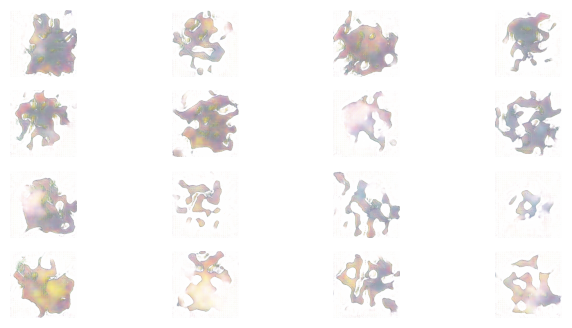

 60%|██████    | 240/400 [21:06<14:42,  5.51s/it]

Time for epoch 240 is 6.302002429962158 sec
Training started with  epoch 241 with 7 batches..


 60%|██████    | 241/400 [21:12<14:21,  5.42s/it]

Losses after epoch   241: generator 6.050, discriminator 0.095,               real_score 96.26%, fake_score 3.20%
Time for epoch 241 is 5.180455446243286 sec
Training started with  epoch 242 with 7 batches..


 60%|██████    | 242/400 [21:17<14:03,  5.34s/it]

Losses after epoch   242: generator 5.051, discriminator 0.074,               real_score 98.09%, fake_score 4.32%
Time for epoch 242 is 5.158206224441528 sec
Training started with  epoch 243 with 7 batches..


 61%|██████    | 243/400 [21:22<13:57,  5.33s/it]

Losses after epoch   243: generator 3.399, discriminator 0.280,               real_score 99.50%, fake_score 15.52%
Time for epoch 243 is 5.308894395828247 sec
Training started with  epoch 244 with 7 batches..


 61%|██████    | 244/400 [21:27<13:43,  5.28s/it]

Losses after epoch   244: generator 4.837, discriminator 0.090,               real_score 99.43%, fake_score 6.32%
Time for epoch 244 is 5.160003662109375 sec
Training started with  epoch 245 with 7 batches..


 61%|██████▏   | 245/400 [21:32<13:32,  5.24s/it]

Losses after epoch   245: generator 4.758, discriminator 0.095,               real_score 99.35%, fake_score 6.32%
Time for epoch 245 is 5.141444444656372 sec
Training started with  epoch 246 with 7 batches..


 62%|██████▏   | 246/400 [21:37<13:23,  5.22s/it]

Losses after epoch   246: generator 5.012, discriminator 0.069,               real_score 98.47%, fake_score 4.31%
Time for epoch 246 is 5.15668797492981 sec
Training started with  epoch 247 with 7 batches..


 62%|██████▏   | 247/400 [21:43<13:14,  5.19s/it]

Losses after epoch   247: generator 4.347, discriminator 0.069,               real_score 99.24%, fake_score 5.22%
Time for epoch 247 is 5.141377925872803 sec
Training started with  epoch 248 with 7 batches..


 62%|██████▏   | 248/400 [21:48<13:07,  5.18s/it]

Losses after epoch   248: generator 5.197, discriminator 0.059,               real_score 99.50%, fake_score 4.56%
Time for epoch 248 is 5.141322135925293 sec
Training started with  epoch 249 with 7 batches..


 62%|██████▏   | 249/400 [21:53<13:00,  5.17s/it]

Losses after epoch   249: generator 5.070, discriminator 0.082,               real_score 99.13%, fake_score 5.38%
Time for epoch 249 is 5.147531270980835 sec
Training started with  epoch 250 with 7 batches..
Losses after epoch   250: generator 5.275, discriminator 0.054,               real_score 99.12%, fake_score 3.54%


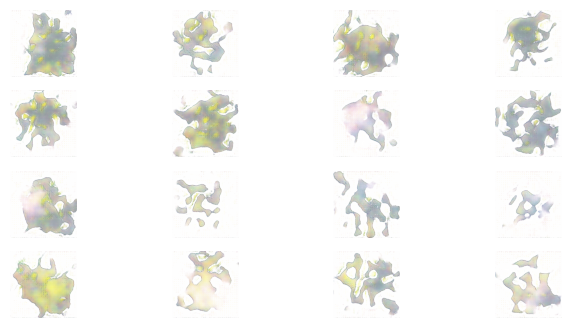

 62%|██████▎   | 250/400 [21:59<13:59,  5.59s/it]

Time for epoch 250 is 6.580254316329956 sec
Training started with  epoch 251 with 7 batches..


 63%|██████▎   | 251/400 [22:05<13:34,  5.47s/it]

Losses after epoch   251: generator 5.596, discriminator 0.060,               real_score 98.62%, fake_score 3.76%
Time for epoch 251 is 5.159360647201538 sec
Training started with  epoch 252 with 7 batches..


 63%|██████▎   | 252/400 [22:10<13:20,  5.41s/it]

Losses after epoch   252: generator 5.803, discriminator 0.049,               real_score 98.43%, fake_score 2.70%
Time for epoch 252 is 5.278465986251831 sec
Training started with  epoch 253 with 7 batches..


 63%|██████▎   | 253/400 [22:15<13:03,  5.33s/it]

Losses after epoch   253: generator 4.975, discriminator 0.111,               real_score 98.80%, fake_score 6.43%
Time for epoch 253 is 5.142684459686279 sec
Training started with  epoch 254 with 7 batches..


 64%|██████▎   | 254/400 [22:20<12:49,  5.27s/it]

Losses after epoch   254: generator 4.382, discriminator 0.100,               real_score 99.55%, fake_score 7.17%
Time for epoch 254 is 5.1381919384002686 sec
Training started with  epoch 255 with 7 batches..


 64%|██████▍   | 255/400 [22:25<12:38,  5.23s/it]

Losses after epoch   255: generator 5.443, discriminator 0.047,               real_score 98.95%, fake_score 3.05%
Time for epoch 255 is 5.134667634963989 sec
Training started with  epoch 256 with 7 batches..


 64%|██████▍   | 256/400 [22:30<12:29,  5.20s/it]

Losses after epoch   256: generator 6.339, discriminator 0.080,               real_score 95.24%, fake_score 1.46%
Time for epoch 256 is 5.136632442474365 sec
Training started with  epoch 257 with 7 batches..


 64%|██████▍   | 257/400 [22:36<12:24,  5.21s/it]

Losses after epoch   257: generator 5.502, discriminator 0.070,               real_score 98.85%, fake_score 4.42%
Time for epoch 257 is 5.208979606628418 sec
Training started with  epoch 258 with 7 batches..


 64%|██████▍   | 258/400 [22:41<12:17,  5.19s/it]

Losses after epoch   258: generator 5.443, discriminator 0.076,               real_score 99.19%, fake_score 4.70%
Time for epoch 258 is 5.158405065536499 sec
Training started with  epoch 259 with 7 batches..


 65%|██████▍   | 259/400 [22:46<12:11,  5.19s/it]

Losses after epoch   259: generator 6.461, discriminator 0.075,               real_score 97.96%, fake_score 3.36%
Time for epoch 259 is 5.167521715164185 sec
Training started with  epoch 260 with 7 batches..
Losses after epoch   260: generator 4.958, discriminator 0.084,               real_score 97.85%, fake_score 4.77%


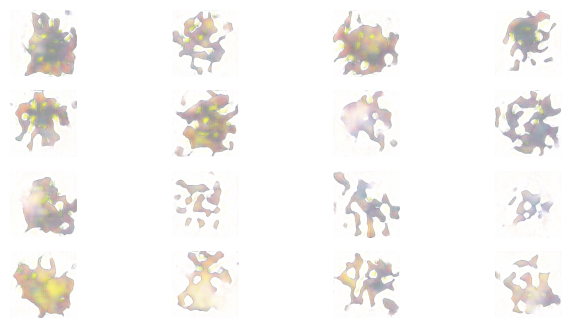

 65%|██████▌   | 260/400 [22:52<12:49,  5.50s/it]

Time for epoch 260 is 6.22908353805542 sec
Training started with  epoch 261 with 7 batches..


 65%|██████▌   | 261/400 [22:57<12:31,  5.41s/it]

Losses after epoch   261: generator 3.712, discriminator 0.166,               real_score 99.03%, fake_score 10.53%
Time for epoch 261 is 5.1811134815216064 sec
Training started with  epoch 262 with 7 batches..


 66%|██████▌   | 262/400 [23:03<12:16,  5.33s/it]

Losses after epoch   262: generator 5.693, discriminator 0.038,               real_score 98.95%, fake_score 2.37%
Time for epoch 262 is 5.16718053817749 sec
Training started with  epoch 263 with 7 batches..


 66%|██████▌   | 263/400 [23:08<12:02,  5.28s/it]

Losses after epoch   263: generator 4.676, discriminator 0.066,               real_score 99.23%, fake_score 4.93%
Time for epoch 263 is 5.137270450592041 sec
Training started with  epoch 264 with 7 batches..


 66%|██████▌   | 264/400 [23:13<11:56,  5.27s/it]

Losses after epoch   264: generator 4.178, discriminator 0.137,               real_score 98.74%, fake_score 8.71%
Time for epoch 264 is 5.2403953075408936 sec
Training started with  epoch 265 with 7 batches..


 66%|██████▋   | 265/400 [23:18<11:45,  5.23s/it]

Losses after epoch   265: generator 0.428, discriminator 2.459,               real_score 100.00%, fake_score 75.21%
Time for epoch 265 is 5.137718915939331 sec
Training started with  epoch 266 with 7 batches..


 66%|██████▋   | 266/400 [23:23<11:40,  5.23s/it]

Losses after epoch   266: generator 19.133, discriminator 2.799,               real_score 30.23%, fake_score 0.00%
Time for epoch 266 is 5.231774091720581 sec
Training started with  epoch 267 with 7 batches..


 67%|██████▋   | 267/400 [23:29<11:32,  5.21s/it]

Losses after epoch   267: generator 9.269, discriminator 0.397,               real_score 84.12%, fake_score 1.12%
Time for epoch 267 is 5.153404235839844 sec
Training started with  epoch 268 with 7 batches..


 67%|██████▋   | 268/400 [23:34<11:25,  5.19s/it]

Losses after epoch   268: generator 0.315, discriminator 4.410,               real_score 100.00%, fake_score 84.70%
Time for epoch 268 is 5.158909797668457 sec
Training started with  epoch 269 with 7 batches..


 67%|██████▋   | 269/400 [23:39<11:19,  5.18s/it]

Losses after epoch   269: generator 0.024, discriminator 10.348,               real_score 100.00%, fake_score 98.22%
Time for epoch 269 is 5.1584765911102295 sec
Training started with  epoch 270 with 7 batches..
Losses after epoch   270: generator 3.776, discriminator 0.345,               real_score 99.97%, fake_score 17.54%


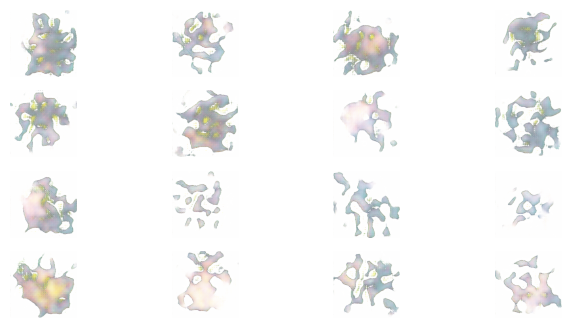

 68%|██████▊   | 270/400 [23:45<12:05,  5.58s/it]

Time for epoch 270 is 6.502000093460083 sec
Training started with  epoch 271 with 7 batches..


 68%|██████▊   | 271/400 [23:51<11:43,  5.46s/it]

Losses after epoch   271: generator 4.640, discriminator 0.200,               real_score 99.18%, fake_score 8.81%
Time for epoch 271 is 5.166290283203125 sec
Training started with  epoch 272 with 7 batches..


 68%|██████▊   | 272/400 [23:56<11:26,  5.37s/it]

Losses after epoch   272: generator 0.026, discriminator 7.897,               real_score 100.00%, fake_score 97.91%
Time for epoch 272 is 5.15187668800354 sec
Training started with  epoch 273 with 7 batches..


 68%|██████▊   | 273/400 [24:01<11:16,  5.33s/it]

Losses after epoch   273: generator 17.201, discriminator 3.268,               real_score 18.51%, fake_score 0.00%
Time for epoch 273 is 5.226411581039429 sec
Training started with  epoch 274 with 7 batches..


 68%|██████▊   | 274/400 [24:06<11:03,  5.27s/it]

Losses after epoch   274: generator 3.793, discriminator 0.398,               real_score 99.90%, fake_score 19.46%
Time for epoch 274 is 5.134508371353149 sec
Training started with  epoch 275 with 7 batches..


 69%|██████▉   | 275/400 [24:11<10:53,  5.23s/it]

Losses after epoch   275: generator 2.457, discriminator 0.671,               real_score 100.00%, fake_score 28.65%
Time for epoch 275 is 5.138529539108276 sec
Training started with  epoch 276 with 7 batches..


 69%|██████▉   | 276/400 [24:16<10:46,  5.21s/it]

Losses after epoch   276: generator 3.974, discriminator 0.297,               real_score 99.75%, fake_score 17.04%
Time for epoch 276 is 5.164331436157227 sec
Training started with  epoch 277 with 7 batches..


 69%|██████▉   | 277/400 [24:22<10:38,  5.19s/it]

Losses after epoch   277: generator 3.939, discriminator 0.205,               real_score 98.93%, fake_score 11.58%
Time for epoch 277 is 5.140859603881836 sec
Training started with  epoch 278 with 7 batches..


 70%|██████▉   | 278/400 [24:27<10:34,  5.20s/it]

Losses after epoch   278: generator 5.544, discriminator 0.096,               real_score 99.05%, fake_score 6.05%
Time for epoch 278 is 5.231617450714111 sec
Training started with  epoch 279 with 7 batches..


 70%|██████▉   | 279/400 [24:32<10:27,  5.19s/it]

Losses after epoch   279: generator 4.083, discriminator 0.270,               real_score 99.82%, fake_score 14.60%
Time for epoch 279 is 5.1407787799835205 sec
Training started with  epoch 280 with 7 batches..
Losses after epoch   280: generator 4.609, discriminator 0.124,               real_score 99.34%, fake_score 8.43%


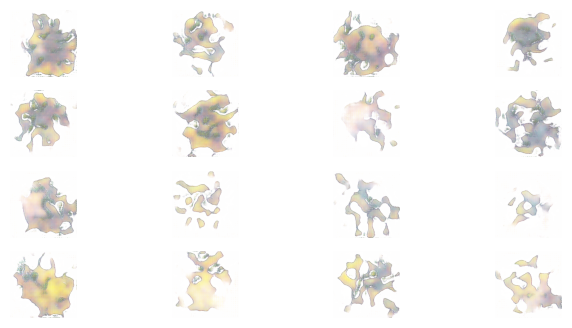

 70%|███████   | 280/400 [24:38<11:01,  5.51s/it]

Time for epoch 280 is 6.2772321701049805 sec
Training started with  epoch 281 with 7 batches..


 70%|███████   | 281/400 [24:43<10:44,  5.42s/it]

Losses after epoch   281: generator 4.698, discriminator 0.173,               real_score 99.71%, fake_score 9.27%
Time for epoch 281 is 5.188006639480591 sec
Training started with  epoch 282 with 7 batches..


 70%|███████   | 282/400 [24:48<10:29,  5.33s/it]

Losses after epoch   282: generator 4.047, discriminator 0.200,               real_score 99.47%, fake_score 13.24%
Time for epoch 282 is 5.137925148010254 sec
Training started with  epoch 283 with 7 batches..


 71%|███████   | 283/400 [24:54<10:17,  5.27s/it]

Losses after epoch   283: generator 5.225, discriminator 0.113,               real_score 98.74%, fake_score 7.02%
Time for epoch 283 is 5.135324001312256 sec
Training started with  epoch 284 with 7 batches..


 71%|███████   | 284/400 [24:59<10:07,  5.24s/it]

Losses after epoch   284: generator 3.923, discriminator 0.197,               real_score 99.69%, fake_score 12.15%
Time for epoch 284 is 5.1599109172821045 sec
Training started with  epoch 285 with 7 batches..


 71%|███████▏  | 285/400 [25:04<10:00,  5.22s/it]

Losses after epoch   285: generator 5.901, discriminator 0.071,               real_score 97.84%, fake_score 3.76%
Time for epoch 285 is 5.162199258804321 sec
Training started with  epoch 286 with 7 batches..


 72%|███████▏  | 286/400 [25:09<09:52,  5.20s/it]

Losses after epoch   286: generator 3.870, discriminator 0.183,               real_score 99.74%, fake_score 11.49%
Time for epoch 286 is 5.142248868942261 sec
Training started with  epoch 287 with 7 batches..


 72%|███████▏  | 287/400 [25:14<09:47,  5.20s/it]

Losses after epoch   287: generator 4.056, discriminator 0.168,               real_score 99.83%, fake_score 10.13%
Time for epoch 287 is 5.219223737716675 sec
Training started with  epoch 288 with 7 batches..


 72%|███████▏  | 288/400 [25:19<09:41,  5.19s/it]

Losses after epoch   288: generator 4.564, discriminator 0.118,               real_score 98.23%, fake_score 7.25%
Time for epoch 288 is 5.163545370101929 sec
Training started with  epoch 289 with 7 batches..


 72%|███████▏  | 289/400 [25:25<09:35,  5.18s/it]

Losses after epoch   289: generator 5.972, discriminator 0.088,               real_score 96.98%, fake_score 4.11%
Time for epoch 289 is 5.154650688171387 sec
Training started with  epoch 290 with 7 batches..
Losses after epoch   290: generator 5.187, discriminator 0.061,               real_score 99.22%, fake_score 4.56%


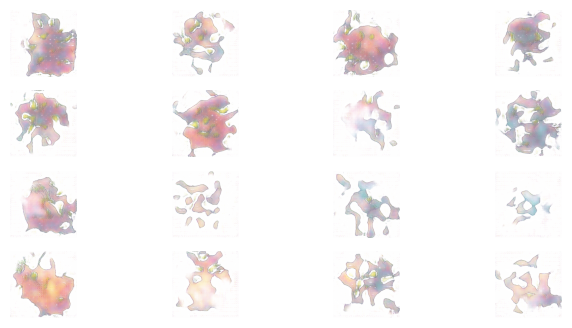

 72%|███████▎  | 290/400 [25:31<10:14,  5.58s/it]

Time for epoch 290 is 6.524718523025513 sec
Training started with  epoch 291 with 7 batches..


 73%|███████▎  | 291/400 [25:36<09:55,  5.46s/it]

Losses after epoch   291: generator 2.014, discriminator 0.658,               real_score 99.65%, fake_score 32.33%
Time for epoch 291 is 5.174034595489502 sec
Training started with  epoch 292 with 7 batches..


 73%|███████▎  | 292/400 [25:42<09:40,  5.38s/it]

Losses after epoch   292: generator 4.863, discriminator 0.123,               real_score 98.86%, fake_score 7.13%
Time for epoch 292 is 5.168996810913086 sec
Training started with  epoch 293 with 7 batches..


 73%|███████▎  | 293/400 [25:47<09:30,  5.33s/it]

Losses after epoch   293: generator 5.535, discriminator 0.082,               real_score 98.93%, fake_score 5.13%
Time for epoch 293 is 5.222205400466919 sec
Training started with  epoch 294 with 7 batches..


 74%|███████▎  | 294/400 [25:52<09:21,  5.29s/it]

Losses after epoch   294: generator 5.534, discriminator 0.080,               real_score 98.90%, fake_score 5.48%
Time for epoch 294 is 5.1995086669921875 sec
Training started with  epoch 295 with 7 batches..


 74%|███████▍  | 295/400 [25:57<09:11,  5.25s/it]

Losses after epoch   295: generator 5.389, discriminator 0.072,               real_score 98.93%, fake_score 4.77%
Time for epoch 295 is 5.155673265457153 sec
Training started with  epoch 296 with 7 batches..


 74%|███████▍  | 296/400 [26:02<09:03,  5.22s/it]

Losses after epoch   296: generator 2.721, discriminator 0.391,               real_score 99.82%, fake_score 23.04%
Time for epoch 296 is 5.157713413238525 sec
Training started with  epoch 297 with 7 batches..


 74%|███████▍  | 297/400 [26:07<08:56,  5.21s/it]

Losses after epoch   297: generator 7.312, discriminator 0.087,               real_score 94.21%, fake_score 0.66%
Time for epoch 297 is 5.162031650543213 sec
Training started with  epoch 298 with 7 batches..


 74%|███████▍  | 298/400 [26:13<08:49,  5.19s/it]

Losses after epoch   298: generator 5.829, discriminator 0.047,               real_score 98.80%, fake_score 2.96%
Time for epoch 298 is 5.157635688781738 sec
Training started with  epoch 299 with 7 batches..


 75%|███████▍  | 299/400 [26:18<08:44,  5.19s/it]

Losses after epoch   299: generator 4.955, discriminator 0.074,               real_score 99.64%, fake_score 5.84%
Time for epoch 299 is 5.182374000549316 sec
Training started with  epoch 300 with 7 batches..
Losses after epoch   300: generator 6.708, discriminator 0.115,               real_score 93.11%, fake_score 1.14%


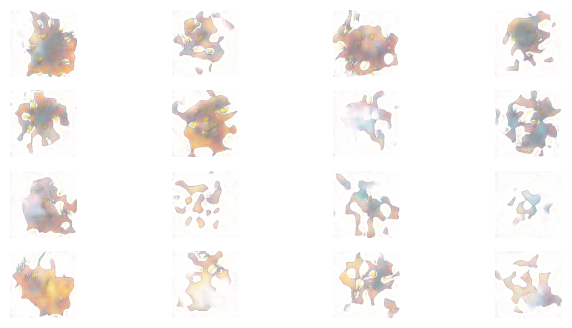

 75%|███████▌  | 300/400 [26:25<09:32,  5.72s/it]

Time for epoch 300 is 6.965163707733154 sec
Training started with  epoch 301 with 7 batches..


 75%|███████▌  | 301/400 [26:30<09:13,  5.59s/it]

Losses after epoch   301: generator 3.570, discriminator 0.155,               real_score 99.66%, fake_score 10.36%
Time for epoch 301 is 5.288275241851807 sec
Training started with  epoch 302 with 7 batches..


 76%|███████▌  | 302/400 [26:35<08:54,  5.46s/it]

Losses after epoch   302: generator 5.104, discriminator 0.083,               real_score 98.27%, fake_score 4.80%
Time for epoch 302 is 5.135753154754639 sec
Training started with  epoch 303 with 7 batches..


 76%|███████▌  | 303/400 [26:40<08:40,  5.36s/it]

Losses after epoch   303: generator 5.594, discriminator 0.081,               real_score 98.55%, fake_score 4.69%
Time for epoch 303 is 5.1408915519714355 sec
Training started with  epoch 304 with 7 batches..


 76%|███████▌  | 304/400 [26:45<08:28,  5.30s/it]

Losses after epoch   304: generator 3.361, discriminator 0.311,               real_score 99.83%, fake_score 16.51%
Time for epoch 304 is 5.158532619476318 sec
Training started with  epoch 305 with 7 batches..


 76%|███████▋  | 305/400 [26:51<08:19,  5.26s/it]

Losses after epoch   305: generator 6.929, discriminator 0.148,               real_score 92.44%, fake_score 0.98%
Time for epoch 305 is 5.16295599937439 sec
Training started with  epoch 306 with 7 batches..


 76%|███████▋  | 306/400 [26:56<08:11,  5.23s/it]

Losses after epoch   306: generator 4.882, discriminator 0.077,               real_score 98.92%, fake_score 5.20%
Time for epoch 306 is 5.160411834716797 sec
Training started with  epoch 307 with 7 batches..


 77%|███████▋  | 307/400 [27:01<08:04,  5.21s/it]

Losses after epoch   307: generator 4.627, discriminator 0.093,               real_score 99.45%, fake_score 6.82%
Time for epoch 307 is 5.157633543014526 sec
Training started with  epoch 308 with 7 batches..


 77%|███████▋  | 308/400 [27:06<08:01,  5.23s/it]

Losses after epoch   308: generator 1.909, discriminator 0.761,               real_score 99.97%, fake_score 36.55%
Time for epoch 308 is 5.281757116317749 sec
Training started with  epoch 309 with 7 batches..


 77%|███████▋  | 309/400 [27:11<07:54,  5.22s/it]

Losses after epoch   309: generator 2.854, discriminator 0.372,               real_score 98.24%, fake_score 20.84%
Time for epoch 309 is 5.174745559692383 sec
Training started with  epoch 310 with 7 batches..
Losses after epoch   310: generator 19.328, discriminator 3.254,               real_score 18.48%, fake_score 0.00%


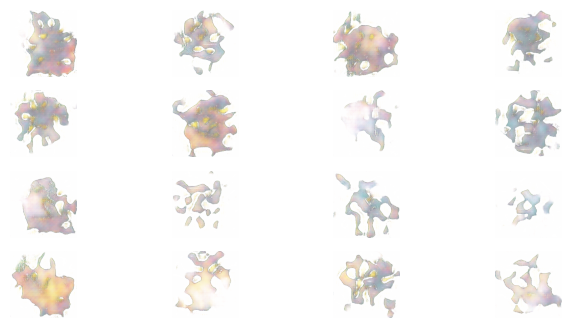

 78%|███████▊  | 310/400 [27:18<08:18,  5.54s/it]

Time for epoch 310 is 6.295026540756226 sec
Training started with  epoch 311 with 7 batches..


 78%|███████▊  | 311/400 [27:23<08:04,  5.44s/it]

Losses after epoch   311: generator 5.244, discriminator 0.084,               real_score 99.49%, fake_score 5.71%
Time for epoch 311 is 5.207377910614014 sec
Training started with  epoch 312 with 7 batches..


 78%|███████▊  | 312/400 [27:28<07:51,  5.35s/it]

Losses after epoch   312: generator 0.321, discriminator 3.542,               real_score 100.00%, fake_score 83.00%
Time for epoch 312 is 5.147765874862671 sec
Training started with  epoch 313 with 7 batches..


 78%|███████▊  | 313/400 [27:33<07:40,  5.30s/it]

Losses after epoch   313: generator 3.861, discriminator 0.152,               real_score 99.98%, fake_score 10.37%
Time for epoch 313 is 5.164514780044556 sec
Training started with  epoch 314 with 7 batches..


 78%|███████▊  | 314/400 [27:38<07:32,  5.26s/it]

Losses after epoch   314: generator 6.482, discriminator 0.107,               real_score 96.33%, fake_score 3.48%
Time for epoch 314 is 5.167382478713989 sec
Training started with  epoch 315 with 7 batches..


 79%|███████▉  | 315/400 [27:44<07:27,  5.27s/it]

Losses after epoch   315: generator 16.101, discriminator 0.150,               real_score 91.40%, fake_score 0.00%
Time for epoch 315 is 5.274380445480347 sec
Training started with  epoch 316 with 7 batches..


 79%|███████▉  | 316/400 [27:49<07:20,  5.24s/it]

Losses after epoch   316: generator 7.593, discriminator 0.225,               real_score 89.80%, fake_score 2.41%
Time for epoch 316 is 5.177542209625244 sec
Training started with  epoch 317 with 7 batches..


 79%|███████▉  | 317/400 [27:54<07:13,  5.22s/it]

Losses after epoch   317: generator 6.863, discriminator 0.094,               real_score 97.54%, fake_score 4.30%
Time for epoch 317 is 5.173457622528076 sec
Training started with  epoch 318 with 7 batches..


 80%|███████▉  | 318/400 [27:59<07:06,  5.20s/it]

Losses after epoch   318: generator 5.340, discriminator 0.108,               real_score 99.35%, fake_score 5.96%
Time for epoch 318 is 5.153122186660767 sec
Training started with  epoch 319 with 7 batches..


 80%|███████▉  | 319/400 [28:04<07:01,  5.20s/it]

Losses after epoch   319: generator 6.949, discriminator 0.071,               real_score 96.90%, fake_score 2.89%
Time for epoch 319 is 5.188695907592773 sec
Training started with  epoch 320 with 7 batches..
Losses after epoch   320: generator 7.092, discriminator 0.061,               real_score 98.02%, fake_score 2.90%


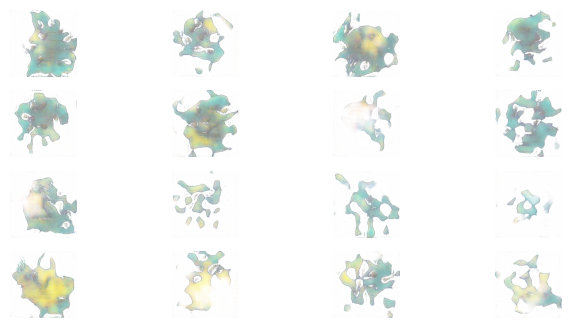

 80%|████████  | 320/400 [28:11<07:23,  5.54s/it]

Time for epoch 320 is 6.332524061203003 sec
Training started with  epoch 321 with 7 batches..


 80%|████████  | 321/400 [28:16<07:09,  5.44s/it]

Losses after epoch   321: generator 5.807, discriminator 0.084,               real_score 97.01%, fake_score 3.74%
Time for epoch 321 is 5.200750112533569 sec
Training started with  epoch 322 with 7 batches..


 80%|████████  | 322/400 [28:21<06:59,  5.37s/it]

Losses after epoch   322: generator 5.012, discriminator 0.066,               real_score 99.91%, fake_score 5.51%
Time for epoch 322 is 5.221039533615112 sec
Training started with  epoch 323 with 7 batches..


 81%|████████  | 323/400 [28:26<06:48,  5.31s/it]

Losses after epoch   323: generator 6.462, discriminator 0.116,               real_score 94.07%, fake_score 2.73%
Time for epoch 323 is 5.157259464263916 sec
Training started with  epoch 324 with 7 batches..


 81%|████████  | 324/400 [28:31<06:40,  5.27s/it]

Losses after epoch   324: generator 4.922, discriminator 0.090,               real_score 99.54%, fake_score 6.05%
Time for epoch 324 is 5.164623022079468 sec
Training started with  epoch 325 with 7 batches..


 81%|████████▏ | 325/400 [28:37<06:32,  5.24s/it]

Losses after epoch   325: generator 6.217, discriminator 0.035,               real_score 98.91%, fake_score 2.18%
Time for epoch 325 is 5.171205282211304 sec
Training started with  epoch 326 with 7 batches..


 82%|████████▏ | 326/400 [28:42<06:25,  5.21s/it]

Losses after epoch   326: generator 5.995, discriminator 0.033,               real_score 99.43%, fake_score 2.38%
Time for epoch 326 is 5.140814304351807 sec
Training started with  epoch 327 with 7 batches..


 82%|████████▏ | 327/400 [28:47<06:19,  5.20s/it]

Losses after epoch   327: generator 4.808, discriminator 0.130,               real_score 99.26%, fake_score 7.91%
Time for epoch 327 is 5.1657395362854 sec
Training started with  epoch 328 with 7 batches..


 82%|████████▏ | 328/400 [28:52<06:13,  5.19s/it]

Losses after epoch   328: generator 5.471, discriminator 0.067,               real_score 98.87%, fake_score 3.95%
Time for epoch 328 is 5.158479690551758 sec
Training started with  epoch 329 with 7 batches..


 82%|████████▏ | 329/400 [28:57<06:09,  5.20s/it]

Losses after epoch   329: generator 5.583, discriminator 0.067,               real_score 99.76%, fake_score 4.67%
Time for epoch 329 is 5.222247123718262 sec
Training started with  epoch 330 with 7 batches..
Losses after epoch   330: generator 6.128, discriminator 0.067,               real_score 98.84%, fake_score 4.00%


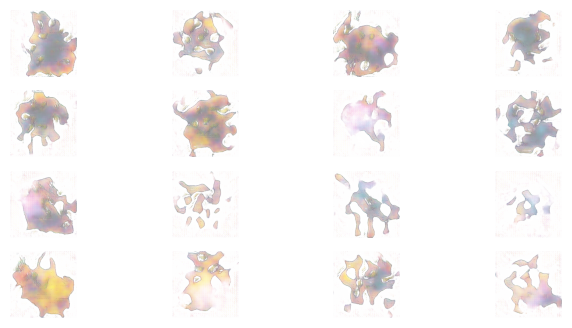

 82%|████████▎ | 330/400 [29:04<06:27,  5.53s/it]

Time for epoch 330 is 6.308351516723633 sec
Training started with  epoch 331 with 7 batches..


 83%|████████▎ | 331/400 [29:09<06:15,  5.44s/it]

Losses after epoch   331: generator 6.920, discriminator 0.055,               real_score 96.43%, fake_score 1.26%
Time for epoch 331 is 5.215606689453125 sec
Training started with  epoch 332 with 7 batches..


 83%|████████▎ | 332/400 [29:14<06:04,  5.35s/it]

Losses after epoch   332: generator 5.734, discriminator 0.074,               real_score 98.09%, fake_score 4.27%
Time for epoch 332 is 5.152321815490723 sec
Training started with  epoch 333 with 7 batches..


 83%|████████▎ | 333/400 [29:19<05:54,  5.30s/it]

Losses after epoch   333: generator 5.872, discriminator 0.047,               real_score 99.37%, fake_score 3.19%
Time for epoch 333 is 5.160141468048096 sec
Training started with  epoch 334 with 7 batches..


 84%|████████▎ | 334/400 [29:24<05:46,  5.26s/it]

Losses after epoch   334: generator 5.444, discriminator 0.097,               real_score 98.78%, fake_score 5.00%
Time for epoch 334 is 5.160271406173706 sec
Training started with  epoch 335 with 7 batches..


 84%|████████▍ | 335/400 [29:30<05:39,  5.22s/it]

Losses after epoch   335: generator 5.929, discriminator 0.098,               real_score 98.55%, fake_score 4.52%
Time for epoch 335 is 5.136329889297485 sec
Training started with  epoch 336 with 7 batches..


 84%|████████▍ | 336/400 [29:35<05:35,  5.24s/it]

Losses after epoch   336: generator 5.708, discriminator 0.082,               real_score 97.17%, fake_score 3.90%
Time for epoch 336 is 5.268490552902222 sec
Training started with  epoch 337 with 7 batches..


 84%|████████▍ | 337/400 [29:40<05:28,  5.21s/it]

Losses after epoch   337: generator 5.706, discriminator 0.058,               real_score 98.90%, fake_score 3.62%
Time for epoch 337 is 5.14853310585022 sec
Training started with  epoch 338 with 7 batches..


 84%|████████▍ | 338/400 [29:45<05:21,  5.19s/it]

Losses after epoch   338: generator 5.337, discriminator 0.068,               real_score 98.38%, fake_score 3.70%
Time for epoch 338 is 5.148141145706177 sec
Training started with  epoch 339 with 7 batches..


 85%|████████▍ | 339/400 [29:50<05:16,  5.18s/it]

Losses after epoch   339: generator 5.670, discriminator 0.082,               real_score 98.11%, fake_score 4.02%
Time for epoch 339 is 5.162572622299194 sec
Training started with  epoch 340 with 7 batches..
Losses after epoch   340: generator 5.355, discriminator 0.062,               real_score 98.39%, fake_score 3.87%


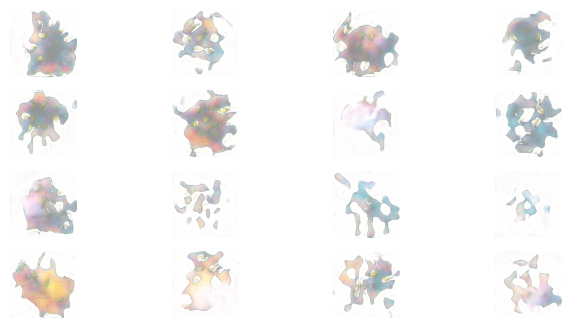

 85%|████████▌ | 340/400 [29:57<05:39,  5.65s/it]

Time for epoch 340 is 6.7483885288238525 sec
Training started with  epoch 341 with 7 batches..


 85%|████████▌ | 341/400 [30:02<05:26,  5.53s/it]

Losses after epoch   341: generator 4.421, discriminator 0.138,               real_score 99.61%, fake_score 9.45%
Time for epoch 341 is 5.2370734214782715 sec
Training started with  epoch 342 with 7 batches..


 86%|████████▌ | 342/400 [30:07<05:13,  5.41s/it]

Losses after epoch   342: generator 5.865, discriminator 0.058,               real_score 97.96%, fake_score 2.94%
Time for epoch 342 is 5.138743162155151 sec
Training started with  epoch 343 with 7 batches..


 86%|████████▌ | 343/400 [30:13<05:06,  5.37s/it]

Losses after epoch   343: generator 4.951, discriminator 0.084,               real_score 98.82%, fake_score 5.83%
Time for epoch 343 is 5.275150537490845 sec
Training started with  epoch 344 with 7 batches..


 86%|████████▌ | 344/400 [30:18<04:57,  5.31s/it]

Losses after epoch   344: generator 6.095, discriminator 0.064,               real_score 96.93%, fake_score 2.30%
Time for epoch 344 is 5.151036024093628 sec
Training started with  epoch 345 with 7 batches..


 86%|████████▋ | 345/400 [30:23<04:49,  5.26s/it]

Losses after epoch   345: generator 5.002, discriminator 0.062,               real_score 99.40%, fake_score 4.41%
Time for epoch 345 is 5.152005910873413 sec
Training started with  epoch 346 with 7 batches..


 86%|████████▋ | 346/400 [30:28<04:42,  5.23s/it]

Losses after epoch   346: generator 6.423, discriminator 0.055,               real_score 97.61%, fake_score 2.17%
Time for epoch 346 is 5.156184196472168 sec
Training started with  epoch 347 with 7 batches..


 87%|████████▋ | 347/400 [30:33<04:36,  5.21s/it]

Losses after epoch   347: generator 5.851, discriminator 0.034,               real_score 98.99%, fake_score 2.13%
Time for epoch 347 is 5.157155990600586 sec
Training started with  epoch 348 with 7 batches..


 87%|████████▋ | 348/400 [30:38<04:29,  5.19s/it]

Losses after epoch   348: generator 4.752, discriminator 0.081,               real_score 99.64%, fake_score 6.05%
Time for epoch 348 is 5.136631488800049 sec
Training started with  epoch 349 with 7 batches..


 87%|████████▋ | 349/400 [30:44<04:24,  5.18s/it]

Losses after epoch   349: generator 5.671, discriminator 0.046,               real_score 98.79%, fake_score 2.78%
Time for epoch 349 is 5.163204669952393 sec
Training started with  epoch 350 with 7 batches..
Losses after epoch   350: generator 6.292, discriminator 0.052,               real_score 98.14%, fake_score 2.35%


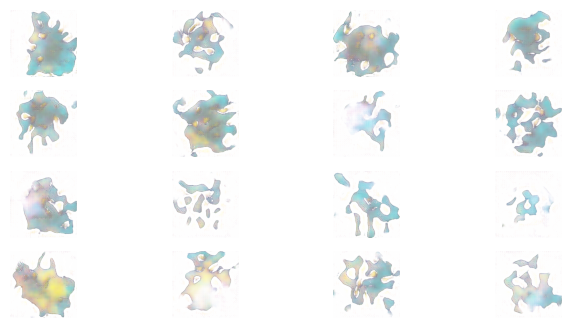

 88%|████████▊ | 350/400 [30:50<04:38,  5.56s/it]

Time for epoch 350 is 6.438419580459595 sec
Training started with  epoch 351 with 7 batches..


 88%|████████▊ | 351/400 [30:55<04:27,  5.45s/it]

Losses after epoch   351: generator 5.728, discriminator 0.067,               real_score 97.45%, fake_score 2.59%
Time for epoch 351 is 5.187334299087524 sec
Training started with  epoch 352 with 7 batches..


 88%|████████▊ | 352/400 [31:00<04:17,  5.37s/it]

Losses after epoch   352: generator 5.011, discriminator 0.075,               real_score 99.24%, fake_score 5.08%
Time for epoch 352 is 5.191238641738892 sec
Training started with  epoch 353 with 7 batches..


 88%|████████▊ | 353/400 [31:06<04:09,  5.31s/it]

Losses after epoch   353: generator 5.034, discriminator 0.071,               real_score 99.46%, fake_score 5.14%
Time for epoch 353 is 5.171317100524902 sec
Training started with  epoch 354 with 7 batches..


 88%|████████▊ | 354/400 [31:11<04:02,  5.27s/it]

Losses after epoch   354: generator 4.823, discriminator 0.081,               real_score 98.17%, fake_score 5.21%
Time for epoch 354 is 5.163647413253784 sec
Training started with  epoch 355 with 7 batches..


 89%|████████▉ | 355/400 [31:16<03:55,  5.24s/it]

Losses after epoch   355: generator 6.617, discriminator 0.047,               real_score 97.02%, fake_score 1.38%
Time for epoch 355 is 5.160746812820435 sec
Training started with  epoch 356 with 7 batches..


 89%|████████▉ | 356/400 [31:21<03:49,  5.22s/it]

Losses after epoch   356: generator 5.108, discriminator 0.100,               real_score 99.37%, fake_score 6.20%
Time for epoch 356 is 5.163306474685669 sec
Training started with  epoch 357 with 7 batches..


 89%|████████▉ | 357/400 [31:26<03:44,  5.22s/it]

Losses after epoch   357: generator 5.197, discriminator 0.051,               real_score 99.50%, fake_score 4.03%
Time for epoch 357 is 5.233181715011597 sec
Training started with  epoch 358 with 7 batches..


 90%|████████▉ | 358/400 [31:31<03:38,  5.20s/it]

Losses after epoch   358: generator 5.282, discriminator 0.066,               real_score 98.84%, fake_score 4.13%
Time for epoch 358 is 5.154468536376953 sec
Training started with  epoch 359 with 7 batches..


 90%|████████▉ | 359/400 [31:37<03:32,  5.19s/it]

Losses after epoch   359: generator 5.654, discriminator 0.072,               real_score 98.89%, fake_score 4.29%
Time for epoch 359 is 5.1581597328186035 sec
Training started with  epoch 360 with 7 batches..
Losses after epoch   360: generator 5.092, discriminator 0.084,               real_score 98.57%, fake_score 5.22%


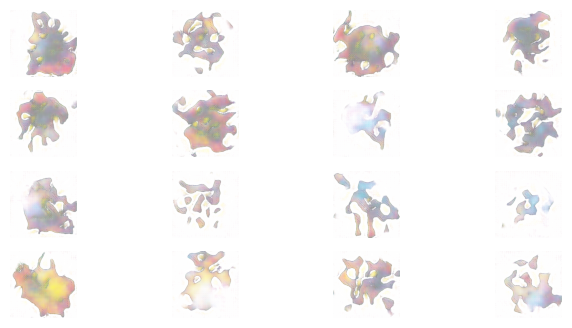

 90%|█████████ | 360/400 [31:43<03:41,  5.53s/it]

Time for epoch 360 is 6.321599245071411 sec
Training started with  epoch 361 with 7 batches..


 90%|█████████ | 361/400 [31:48<03:31,  5.43s/it]

Losses after epoch   361: generator 5.788, discriminator 0.063,               real_score 96.79%, fake_score 2.23%
Time for epoch 361 is 5.190424680709839 sec
Training started with  epoch 362 with 7 batches..


 90%|█████████ | 362/400 [31:53<03:23,  5.34s/it]

Losses after epoch   362: generator 3.938, discriminator 0.218,               real_score 99.73%, fake_score 13.00%
Time for epoch 362 is 5.140625 sec
Training started with  epoch 363 with 7 batches..


 91%|█████████ | 363/400 [31:58<03:15,  5.29s/it]

Losses after epoch   363: generator 5.761, discriminator 0.077,               real_score 98.19%, fake_score 4.03%
Time for epoch 363 is 5.150239706039429 sec
Training started with  epoch 364 with 7 batches..


 91%|█████████ | 364/400 [32:04<03:09,  5.27s/it]

Losses after epoch   364: generator 5.239, discriminator 0.078,               real_score 99.32%, fake_score 5.25%
Time for epoch 364 is 5.238930940628052 sec
Training started with  epoch 365 with 7 batches..


 91%|█████████▏| 365/400 [32:09<03:03,  5.24s/it]

Losses after epoch   365: generator 6.125, discriminator 0.050,               real_score 97.69%, fake_score 1.95%
Time for epoch 365 is 5.1592700481414795 sec
Training started with  epoch 366 with 7 batches..


 92%|█████████▏| 366/400 [32:14<02:57,  5.22s/it]

Losses after epoch   366: generator 6.271, discriminator 0.038,               real_score 98.10%, fake_score 1.50%
Time for epoch 366 is 5.15693736076355 sec
Training started with  epoch 367 with 7 batches..


 92%|█████████▏| 367/400 [32:19<02:51,  5.19s/it]

Losses after epoch   367: generator 6.307, discriminator 0.088,               real_score 96.74%, fake_score 3.28%
Time for epoch 367 is 5.1352527141571045 sec
Training started with  epoch 368 with 7 batches..


 92%|█████████▏| 368/400 [32:24<02:45,  5.18s/it]

Losses after epoch   368: generator 4.609, discriminator 0.100,               real_score 99.50%, fake_score 7.28%
Time for epoch 368 is 5.154499053955078 sec
Training started with  epoch 369 with 7 batches..


 92%|█████████▏| 369/400 [32:29<02:40,  5.18s/it]

Losses after epoch   369: generator 6.184, discriminator 0.067,               real_score 98.44%, fake_score 3.64%
Time for epoch 369 is 5.161128997802734 sec
Training started with  epoch 370 with 7 batches..
Losses after epoch   370: generator 5.954, discriminator 0.043,               real_score 98.82%, fake_score 2.60%


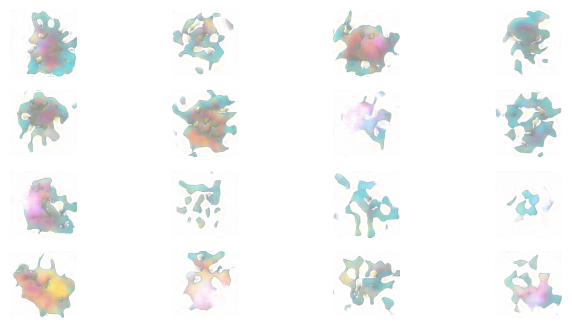

 92%|█████████▎| 370/400 [32:36<02:50,  5.67s/it]

Time for epoch 370 is 6.823265552520752 sec
Training started with  epoch 371 with 7 batches..


 93%|█████████▎| 371/400 [32:42<02:41,  5.56s/it]

Losses after epoch   371: generator 4.834, discriminator 0.078,               real_score 99.87%, fake_score 5.88%
Time for epoch 371 is 5.31064772605896 sec
Training started with  epoch 372 with 7 batches..


 93%|█████████▎| 372/400 [32:47<02:32,  5.45s/it]

Losses after epoch   372: generator 5.256, discriminator 0.093,               real_score 99.00%, fake_score 5.97%
Time for epoch 372 is 5.1696693897247314 sec
Training started with  epoch 373 with 7 batches..


 93%|█████████▎| 373/400 [32:52<02:25,  5.38s/it]

Losses after epoch   373: generator 5.897, discriminator 0.085,               real_score 99.09%, fake_score 4.60%
Time for epoch 373 is 5.235479116439819 sec
Training started with  epoch 374 with 7 batches..


 94%|█████████▎| 374/400 [32:57<02:18,  5.32s/it]

Losses after epoch   374: generator 5.486, discriminator 0.054,               real_score 99.55%, fake_score 3.99%
Time for epoch 374 is 5.1584343910217285 sec
Training started with  epoch 375 with 7 batches..


 94%|█████████▍| 375/400 [33:02<02:11,  5.27s/it]

Losses after epoch   375: generator 4.840, discriminator 0.085,               real_score 99.21%, fake_score 5.65%
Time for epoch 375 is 5.161050796508789 sec
Training started with  epoch 376 with 7 batches..


 94%|█████████▍| 376/400 [33:08<02:05,  5.24s/it]

Losses after epoch   376: generator 5.549, discriminator 0.068,               real_score 99.32%, fake_score 4.22%
Time for epoch 376 is 5.168133974075317 sec
Training started with  epoch 377 with 7 batches..


 94%|█████████▍| 377/400 [33:13<02:00,  5.22s/it]

Losses after epoch   377: generator 4.225, discriminator 0.133,               real_score 99.51%, fake_score 9.68%
Time for epoch 377 is 5.181573867797852 sec
Training started with  epoch 378 with 7 batches..


 94%|█████████▍| 378/400 [33:18<01:54,  5.23s/it]

Losses after epoch   378: generator 4.538, discriminator 0.097,               real_score 99.60%, fake_score 7.60%
Time for epoch 378 is 5.2298829555511475 sec
Training started with  epoch 379 with 7 batches..


 95%|█████████▍| 379/400 [33:23<01:49,  5.21s/it]

Losses after epoch   379: generator 5.312, discriminator 0.064,               real_score 99.03%, fake_score 4.26%
Time for epoch 379 is 5.171859979629517 sec
Training started with  epoch 380 with 7 batches..
Losses after epoch   380: generator 5.268, discriminator 0.113,               real_score 99.24%, fake_score 6.77%


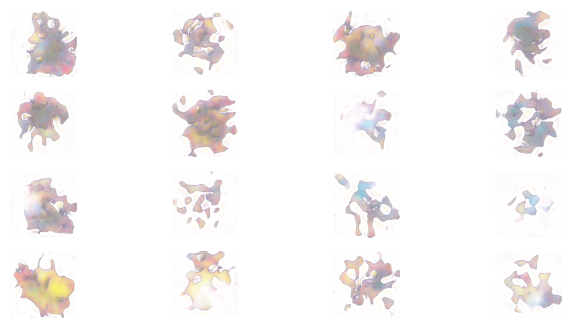

 95%|█████████▌| 380/400 [33:30<01:53,  5.65s/it]

Time for epoch 380 is 6.681716203689575 sec
Training started with  epoch 381 with 7 batches..


 95%|█████████▌| 381/400 [33:35<01:44,  5.52s/it]

Losses after epoch   381: generator 5.317, discriminator 0.070,               real_score 98.85%, fake_score 4.19%
Time for epoch 381 is 5.210806369781494 sec
Training started with  epoch 382 with 7 batches..


 96%|█████████▌| 382/400 [33:40<01:37,  5.41s/it]

Losses after epoch   382: generator 6.837, discriminator 0.082,               real_score 95.54%, fake_score 1.99%
Time for epoch 382 is 5.144528865814209 sec
Training started with  epoch 383 with 7 batches..


 96%|█████████▌| 383/400 [33:45<01:30,  5.33s/it]

Losses after epoch   383: generator 5.432, discriminator 0.060,               real_score 98.95%, fake_score 3.68%
Time for epoch 383 is 5.161043882369995 sec
Training started with  epoch 384 with 7 batches..


 96%|█████████▌| 384/400 [33:50<01:24,  5.28s/it]

Losses after epoch   384: generator 6.310, discriminator 0.093,               real_score 95.62%, fake_score 2.15%
Time for epoch 384 is 5.141425609588623 sec
Training started with  epoch 385 with 7 batches..


 96%|█████████▋| 385/400 [33:56<01:18,  5.25s/it]

Losses after epoch   385: generator 6.479, discriminator 0.087,               real_score 97.54%, fake_score 2.50%
Time for epoch 385 is 5.175130367279053 sec
Training started with  epoch 386 with 7 batches..


 96%|█████████▋| 386/400 [34:01<01:13,  5.22s/it]

Losses after epoch   386: generator 5.502, discriminator 0.039,               real_score 99.31%, fake_score 2.96%
Time for epoch 386 is 5.1415393352508545 sec
Training started with  epoch 387 with 7 batches..


 97%|█████████▋| 387/400 [34:06<01:07,  5.22s/it]

Losses after epoch   387: generator 5.791, discriminator 0.062,               real_score 98.41%, fake_score 2.49%
Time for epoch 387 is 5.236290693283081 sec
Training started with  epoch 388 with 7 batches..


 97%|█████████▋| 388/400 [34:11<01:02,  5.20s/it]

Losses after epoch   388: generator 6.869, discriminator 0.028,               real_score 98.75%, fake_score 1.25%
Time for epoch 388 is 5.155722379684448 sec
Training started with  epoch 389 with 7 batches..


 97%|█████████▋| 389/400 [34:16<00:57,  5.18s/it]

Losses after epoch   389: generator 6.318, discriminator 0.042,               real_score 99.08%, fake_score 2.51%
Time for epoch 389 is 5.139772176742554 sec
Training started with  epoch 390 with 7 batches..
Losses after epoch   390: generator 5.061, discriminator 0.088,               real_score 99.43%, fake_score 5.79%


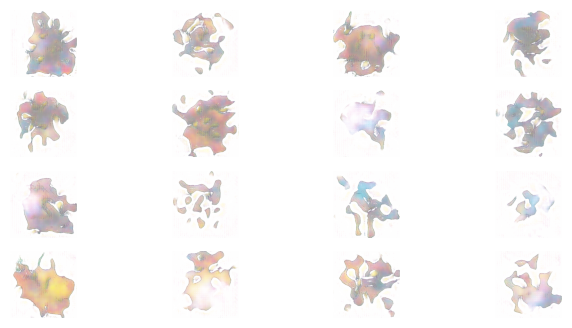

 98%|█████████▊| 390/400 [34:23<00:55,  5.51s/it]

Time for epoch 390 is 6.25199818611145 sec
Training started with  epoch 391 with 7 batches..


 98%|█████████▊| 391/400 [34:28<00:48,  5.41s/it]

Losses after epoch   391: generator 5.284, discriminator 0.072,               real_score 99.21%, fake_score 5.13%
Time for epoch 391 is 5.19226598739624 sec
Training started with  epoch 392 with 7 batches..


 98%|█████████▊| 392/400 [34:33<00:42,  5.34s/it]

Losses after epoch   392: generator 5.030, discriminator 0.111,               real_score 98.89%, fake_score 6.60%
Time for epoch 392 is 5.154138565063477 sec
Training started with  epoch 393 with 7 batches..


 98%|█████████▊| 393/400 [34:38<00:36,  5.28s/it]

Losses after epoch   393: generator 5.242, discriminator 0.076,               real_score 98.88%, fake_score 4.85%
Time for epoch 393 is 5.158109903335571 sec
Training started with  epoch 394 with 7 batches..


 98%|█████████▊| 394/400 [34:43<00:31,  5.29s/it]

Losses after epoch   394: generator 5.965, discriminator 0.059,               real_score 97.86%, fake_score 2.74%
Time for epoch 394 is 5.292941093444824 sec
Training started with  epoch 395 with 7 batches..


 99%|█████████▉| 395/400 [34:49<00:26,  5.25s/it]

Losses after epoch   395: generator 6.159, discriminator 0.075,               real_score 95.42%, fake_score 1.32%
Time for epoch 395 is 5.160139322280884 sec
Training started with  epoch 396 with 7 batches..


 99%|█████████▉| 396/400 [34:54<00:20,  5.22s/it]

Losses after epoch   396: generator 0.012, discriminator 7.462,               real_score 100.00%, fake_score 98.97%
Time for epoch 396 is 5.13800048828125 sec
Training started with  epoch 397 with 7 batches..


 99%|█████████▉| 397/400 [34:59<00:15,  5.20s/it]

Losses after epoch   397: generator 0.000, discriminator 12.549,               real_score 100.00%, fake_score 99.99%
Time for epoch 397 is 5.155874013900757 sec
Training started with  epoch 398 with 7 batches..


100%|█████████▉| 398/400 [35:04<00:10,  5.18s/it]

Losses after epoch   398: generator 17.414, discriminator 5.921,               real_score 3.32%, fake_score 0.00%
Time for epoch 398 is 5.145991325378418 sec
Training started with  epoch 399 with 7 batches..


100%|█████████▉| 399/400 [35:09<00:05,  5.19s/it]

Losses after epoch   399: generator 30.959, discriminator 1.043,               real_score 64.90%, fake_score 0.00%
Time for epoch 399 is 5.2180540561676025 sec
Training started with  epoch 400 with 7 batches..
Losses after epoch   400: generator 11.183, discriminator 1.276,               real_score 59.94%, fake_score 0.34%


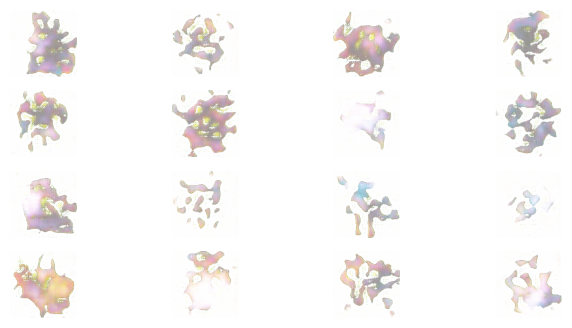

100%|██████████| 400/400 [35:16<00:00,  5.29s/it]

Time for epoch 400 is 6.728522777557373 sec


In [37]:
# Call the train function to train the models
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(dataset, epochs = epochs)

# Result - Graphs (Loss and Accuracy)

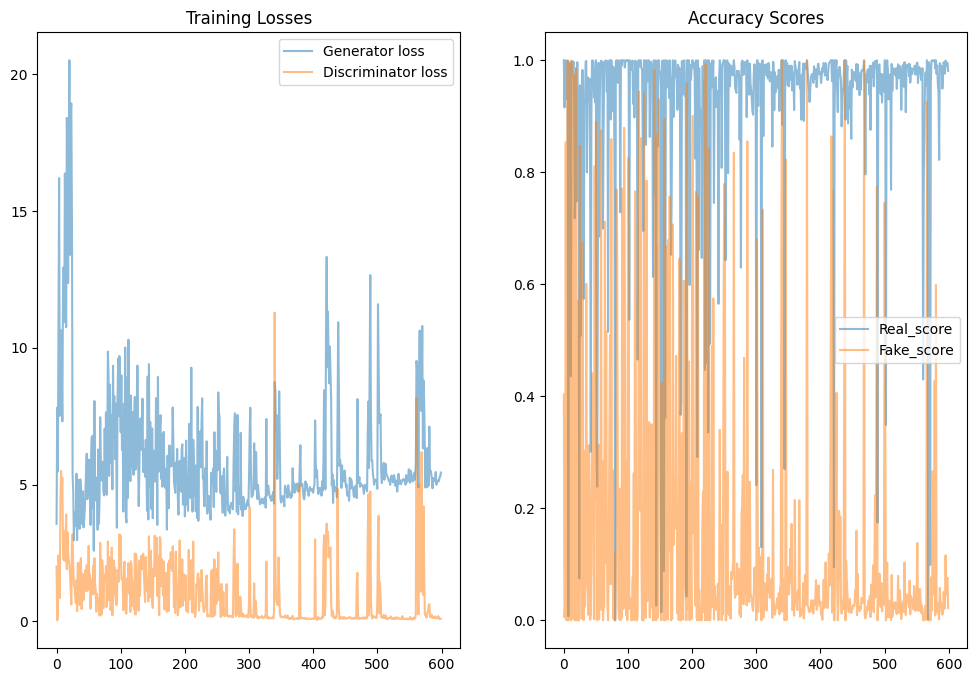

In [28]:

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(real_score_list, label = 'Real_score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake_score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()

# Save the Models, Data, and other files

In [29]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
generator.save('/content/PokeGAN_1_dot_0_generator.h5')

In [30]:
discriminator.save('/content/PokeGAN_1_dot_0_discriminator.h5')

# Re-Load the generator and generate a new Pokemon

In [31]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/PokeGAN_1_dot_0_generator.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      5

(1, 256, 256, 3)
tf.Tensor(
[[[0.9950671  0.99251753 0.99072236]
  [0.9996446  0.9995009  0.9986732 ]
  [0.9993837  0.9987368  0.9985908 ]
  [0.99909097 0.99887383 0.9977214 ]
  [0.99606127 0.9925955  0.99520636]]

 [[0.9955744  0.9973875  0.9968622 ]
  [0.9999369  0.99964994 0.9999097 ]
  [0.9997889  0.99952036 0.9995217 ]
  [0.99862534 0.9948851  0.9987111 ]
  [0.9974681  0.99565977 0.99717486]]

 [[0.99952066 0.9975788  0.99824333]
  [0.99975723 0.99950206 0.99879146]
  [0.9986817  0.99707663 0.99807024]
  [0.99820095 0.9974972  0.99607736]
  [0.9948936  0.98942053 0.9889934 ]]

 [[0.9962116  0.99719423 0.99730754]
  [0.99685305 0.9934043  0.9978853 ]
  [0.98317254 0.98126173 0.9873808 ]
  [0.950088   0.9008101  0.9472854 ]
  [0.95808053 0.9775423  0.9666703 ]]

 [[0.9939332  0.99094784 0.9926435 ]
  [0.99832994 0.9980038  0.99703425]
  [0.9959362  0.9877461  0.9962024 ]
  [0.98617417 0.9932828  0.978312  ]
  [0.9698482  0.9752799  0.96185184]]], shape=(5, 5, 3), dtype=float32)


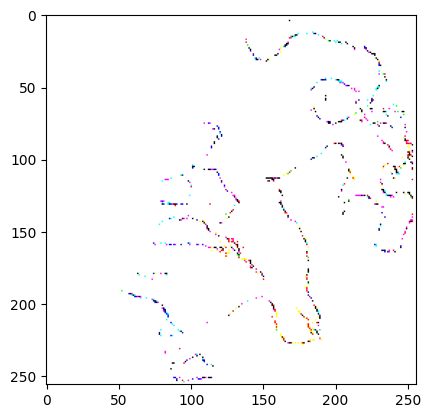

In [32]:
noise = tf.random.normal([1, 100])

generated_image = new_model(noise, training = False)

print(generated_image.shape)
print(generated_image[0, :5, :5])
plt.imshow((generated_image[0, :, :, :] * 255 * 100))

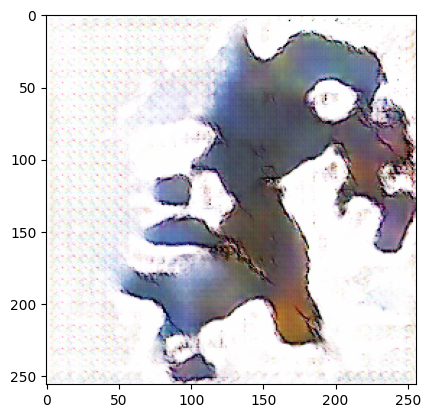

In [33]:
plt.imshow((generated_image[0, :, :, :]))

In [ ]:
test_input = tf.random.normal([num_examples_to_generate, noise_dim])

predictions = new_model(test_input, training = False)

fig = plt.figure(figsize = (8, 4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((predictions[i, :, :, :]))
    plt.axis('off')
plt.show()

# Conclusion

Since, the results, have not been satisfying, I'll try again with the 2.0 version.

In case, you reached here, do give a star ⭐ to this repository!!

*Any suggestions/feedback will be appreciated.*

**Thank You**

# Saving Models on GDrive

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

In [ ]:
shutil.copy("/content/PokeGAN_1_dot_0_generator.h5","/content/drive/MyDrive/PokeGAN_1.0")
shutil.copy("/content/PokeGAN_1_dot_0_discriminator.h5","/content/drive/MyDrive/PokeGAN_1.0")

# <center>E.O.F.</center>